# DESCRIPTIVE ANALYSIS

In [141]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings

# Ignore harmless warnings.
warnings.filterwarnings("ignore")

# Set figure size and dpi. Note that high values might cause lag in slow machines:
plt.rcParams['figure.figsize'] = (10,5)
plt.rcParams['figure.dpi'] = 150

# Set pandas column display format to 4 precion:
pd.options.display.float_format = '{:.4f}'.format

## READ DATA

In [142]:
# Set data directory
data_dir = '../data/'

In [143]:
# Read data into memory:
df = pd.read_csv(data_dir + 'data.csv')
df.head()

,country,code,year,n,pop,I,y,TRADE,INST,HC,FINANCIAL,OECD
0,Algeria,DZA,1996,1.7633,28984634.0000,25.6784,2927.3774,53.7051,-1.2182,1.7472,91.5847,0
1,Algeria,DZA,1997,1.6812,29476031.0000,22.4470,2910.2392,52.2439,-1.2083,1.7807,93.6758,0
2,Algeria,DZA,1998,1.5106,29924668.0000,27.1485,3012.8054,45.0945,-1.1984,1.8148,91.6812,0
3,Algeria,DZA,1999,1.3984,30346083.0000,26.2477,3066.0377,50.9291,-1.2221,1.8496,80.1083,0
4,Algeria,DZA,2000,1.4023,30774621.0000,23.5639,3138.2300,62.8583,-1.2458,1.8851,81.1204,0


## DTYPE FIXES and SCALING

In [144]:
len(range(1996, 2023))

27

In [145]:
# Rename some variables for better presentation:
df.columns

Index(['country', 'code', 'year', 'n', 'pop', 'I', 'y', 'TRADE', 'INST', 'HC',
       'FINANCIAL', 'OECD'],
      dtype='object')

In [146]:
# Display data info:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2646 entries, 0 to 2645
Data columns (total 12 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   country    2646 non-null   object 
 1   code       2646 non-null   object 
 2   year       2646 non-null   int64  
 3   n          2646 non-null   float64
 4   pop        2646 non-null   float64
 5   I          2646 non-null   float64
 6   y          2646 non-null   float64
 7   TRADE      2646 non-null   float64
 8   INST       2646 non-null   float64
 9   HC         2646 non-null   float64
 10  FINANCIAL  2646 non-null   float64
 11  OECD       2646 non-null   int64  
dtypes: float64(8), int64(2), object(2)
memory usage: 248.2+ KB


In [147]:
# Calculate natural logarithms:
df['ln_y'] = np.log(df['y'])

## PANEL DESCRIPTIVE STATISTICS

In [148]:
# Calculate total descriptive statistics:
df[['y', 'I', 'n', 'HC',
    'INST', 'TRADE', 'FINANCIAL']]\
        .agg(['count', 'mean', 'std',
              'median', 'min', 'max']).T

,count,mean,std,median,min,max
y,2646.0000,13952.6192,17996.0819,5751.6042,262.1848,97316.8775
I,2646.0000,23.1834,6.7791,22.6501,-2.4244,58.1507
n,2646.0000,1.2342,1.2583,1.2066,-14.2570,16.6255
HC,2646.0000,2.5540,0.7236,2.6034,1.0533,4.8561
INST,2646.0000,0.1121,0.9858,-0.1285,-1.8700,2.1248
TRADE,2646.0000,76.6849,46.8344,64.5309,2.6988,437.3267
FINANCIAL,2646.0000,288.9295,651.4233,138.8401,6.7903,9683.7045


## BOX PLOT and OUTLIER DETECTION

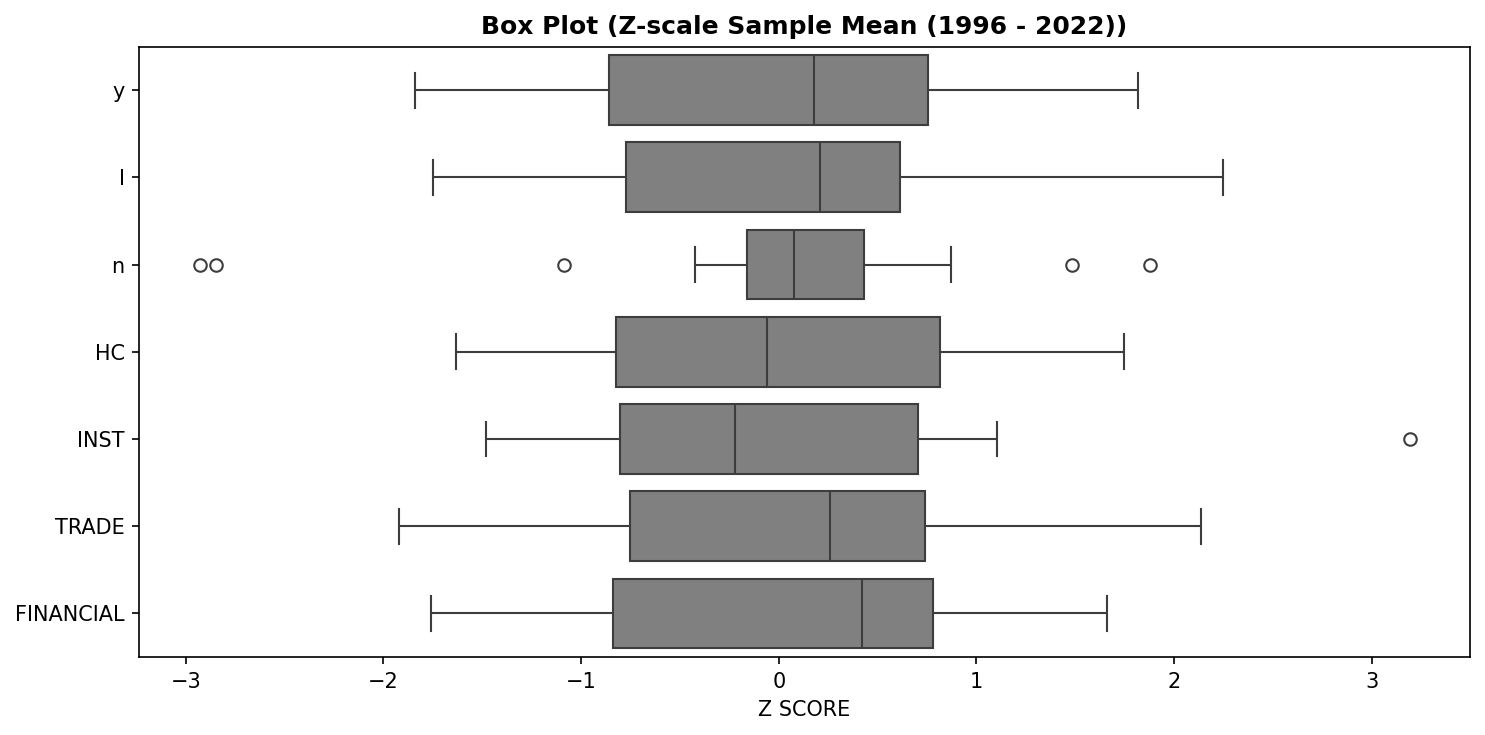

In [149]:
# Get z values of data:
z_data = zscore(df.drop(columns=['code', 'country']).groupby(by=['year']).mean()\
    [['y', 'I', 'n', 'HC',
      'INST', 'TRADE', 'FINANCIAL']])

# Boxplot
plt.figure(figsize=(10,5))

sns.boxplot(data=z_data, color='gray', orient='h')
plt.title('Box Plot (Z-scale Sample Mean (1996 - 2022))',
          fontdict={'weight': 'bold'})

plt.xlabel('Z SCORE')

plt.tight_layout()
plt.show()

## 5 YEAR INTERVAL DESCRIPTIVE STATISTICS

In [150]:
# Calculate yearly descriptive statistics for every year:
world_year_group =df[['year', 'y', 'I',
                      'n', 'HC', 'INST', 'TRADE', 'FINANCIAL']].groupby(by='year', as_index=False).mean()

# Define intervals:
intervals = [(1996, 2001), (2001, 2006),
             (2006, 2011), (2011, 2016),
             (2017, 2022)]

# Generate intervals dataframe:
year_intervals_df = pd.DataFrame(columns=['y', 'I', 'n', 'HC',
                                          'INST', 'TRADE', 'FINANCIAL', 'interval'])

for start, end in intervals:
    # Get intervals:
    temp = world_year_group.query('@start <= year <= @end')
    
    # Set interval information:
    temp['interval'] = f'{start}-{end}'
    temp = temp.drop(columns=['year']) # drop year column for consistency.
    year_intervals_df = pd.concat([year_intervals_df, temp], ignore_index=True)

columns_to_select = year_intervals_df.drop(columns='interval').columns.to_list()
year_intervals_df.groupby('interval')\
    .mean().T

interval,1996-2001,2001-2006,2006-2011,2011-2016,2017-2022
y,11522.9984,12886.2244,14079.3731,14777.5315,16245.3900
I,21.8112,22.4961,24.3415,23.7097,23.6477
n,1.3392,1.2559,1.2867,1.2284,1.0682
HC,2.3414,2.4397,2.5352,2.6417,2.7793
INST,0.1135,0.0886,0.0976,0.1279,0.1240
TRADE,69.0677,75.0089,79.7923,80.3676,79.9600
FINANCIAL,156.3478,216.6202,298.0338,355.3041,401.1383


## TIME SERIES PLOTS WITH SAMPLE AVERAGE (1996 - 2022)

In [151]:
# Define linear trend line function:
def trend_line(x: np.array, y: np.ndarray, color: str) -> None:
    """Return trendline plot for given data
    with the assumption that x is datetime data."""
    
    # Find fittet line:
    linear_fit = np.polyfit(x, y, 1)
    p = np.poly1d(linear_fit)
    # Plot the line:
    plt.plot(x, p(x), ls=':', color=color, alpha=1,
             lw=2, label='Trend Line')

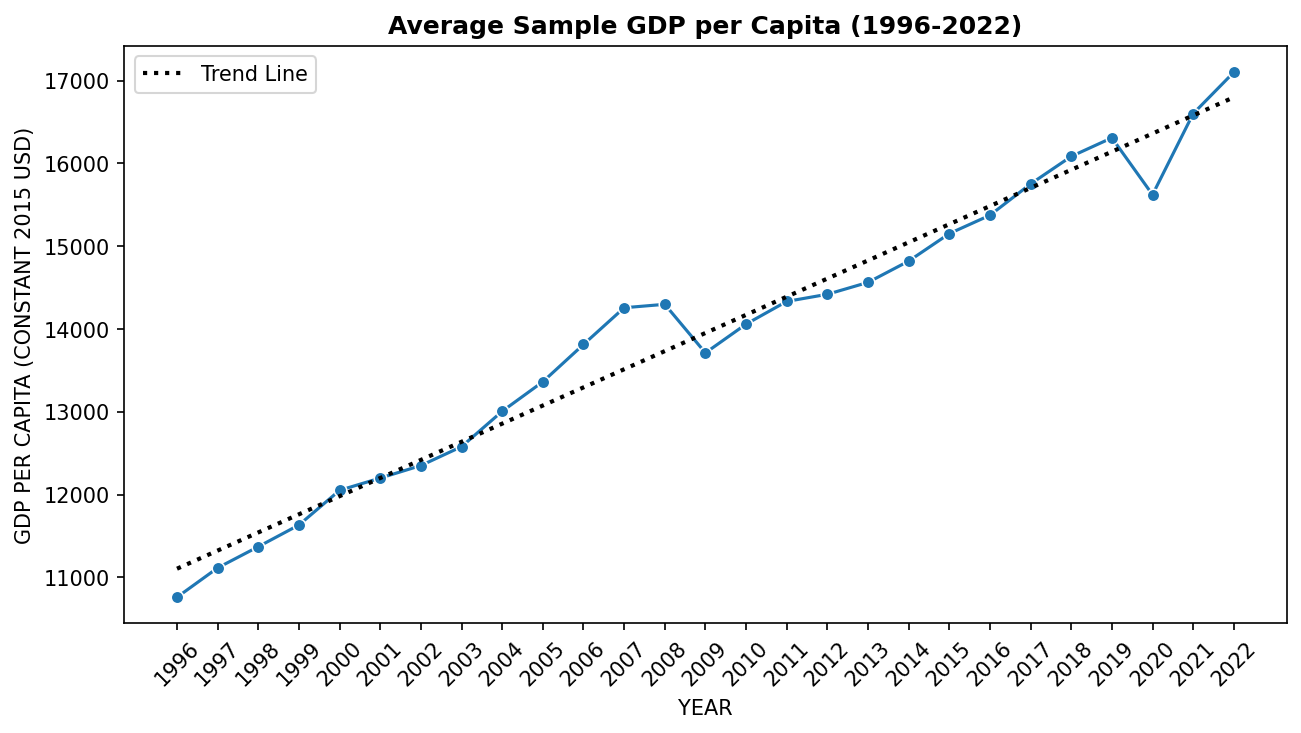

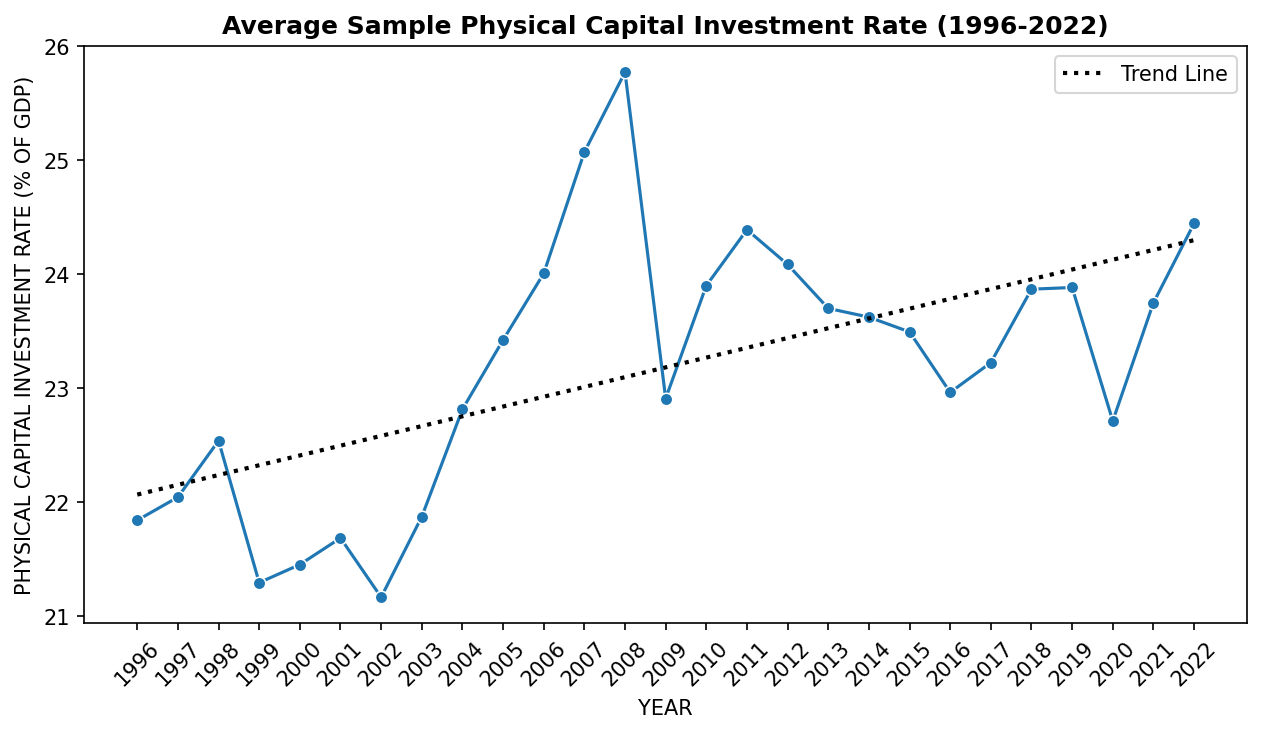

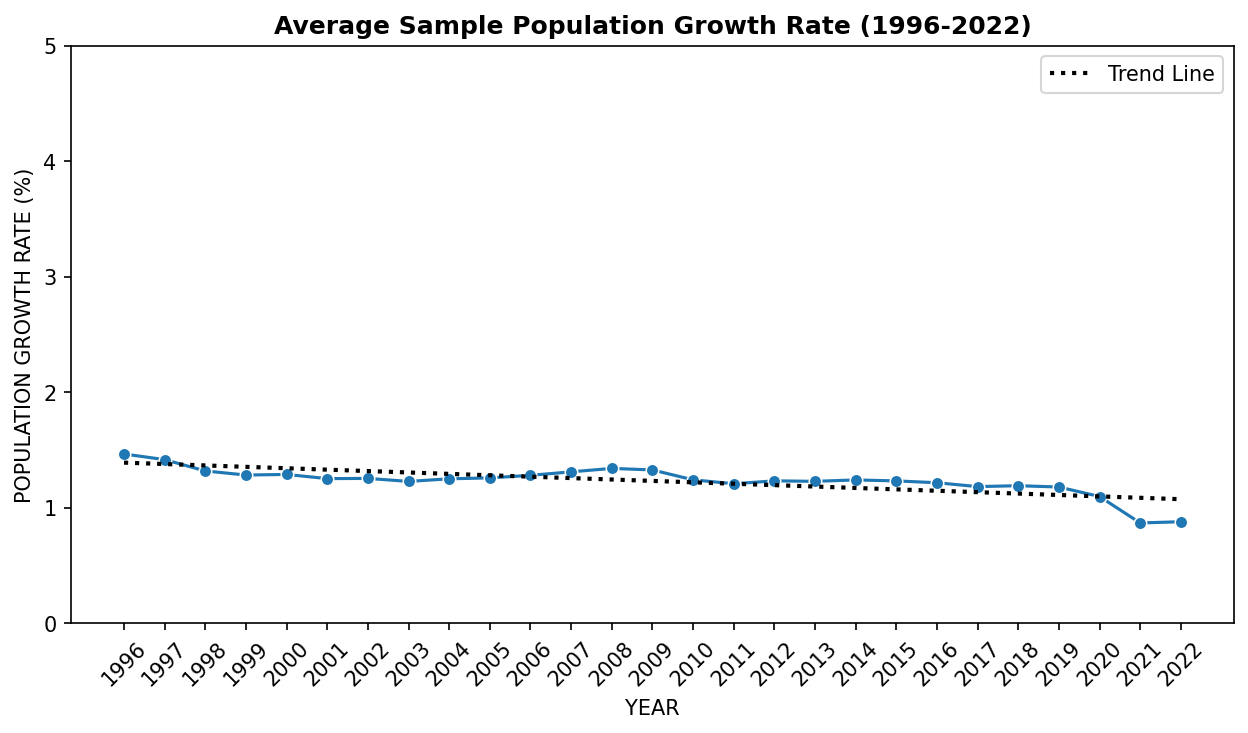

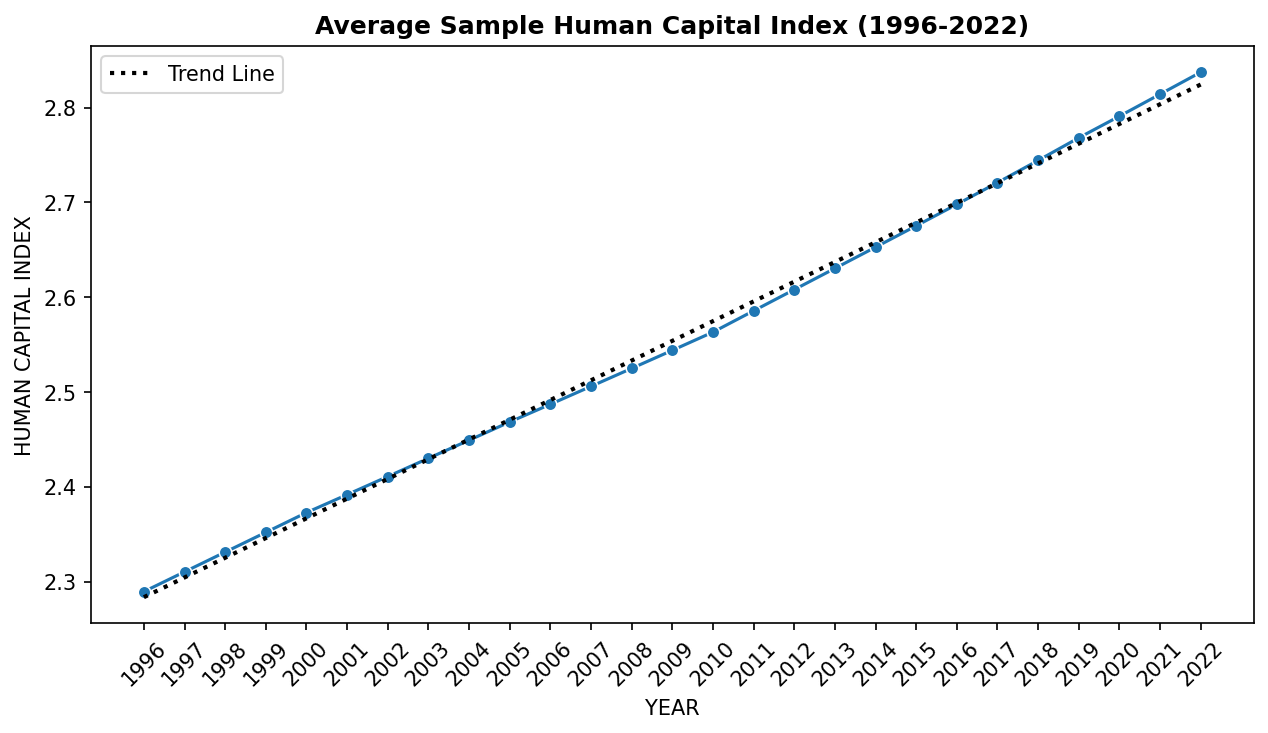

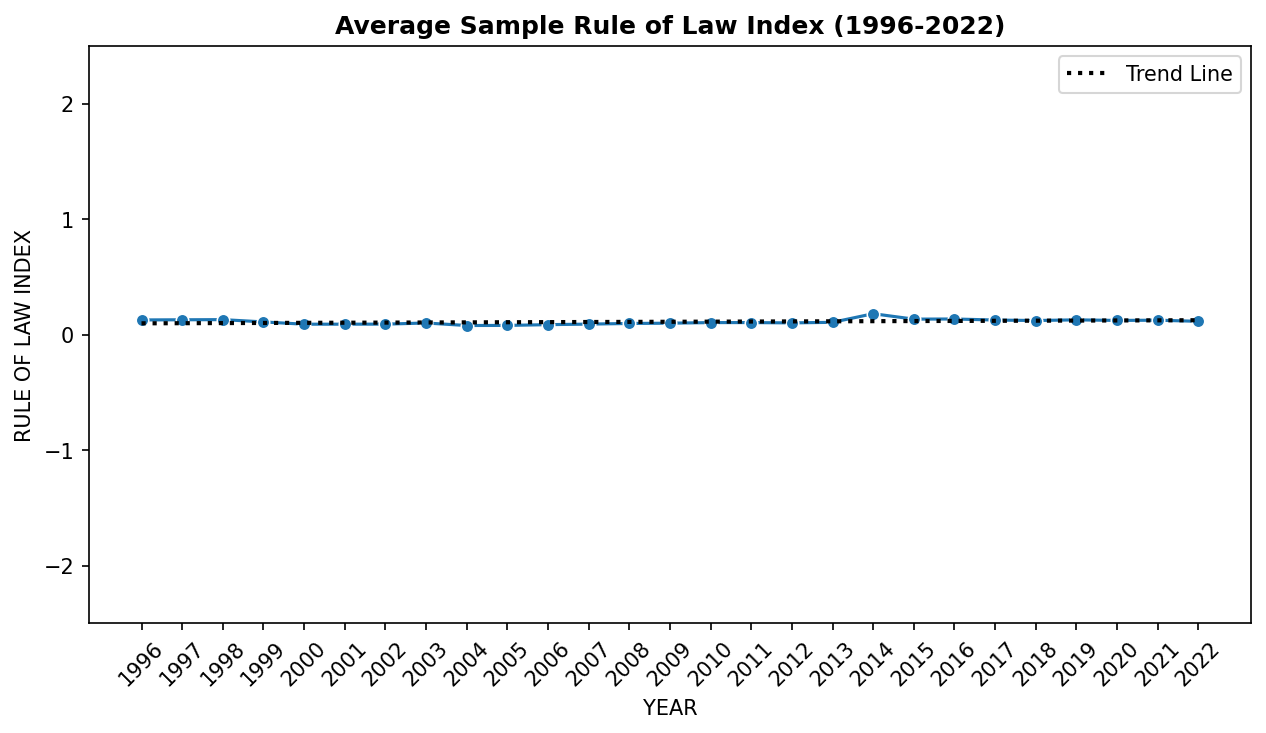

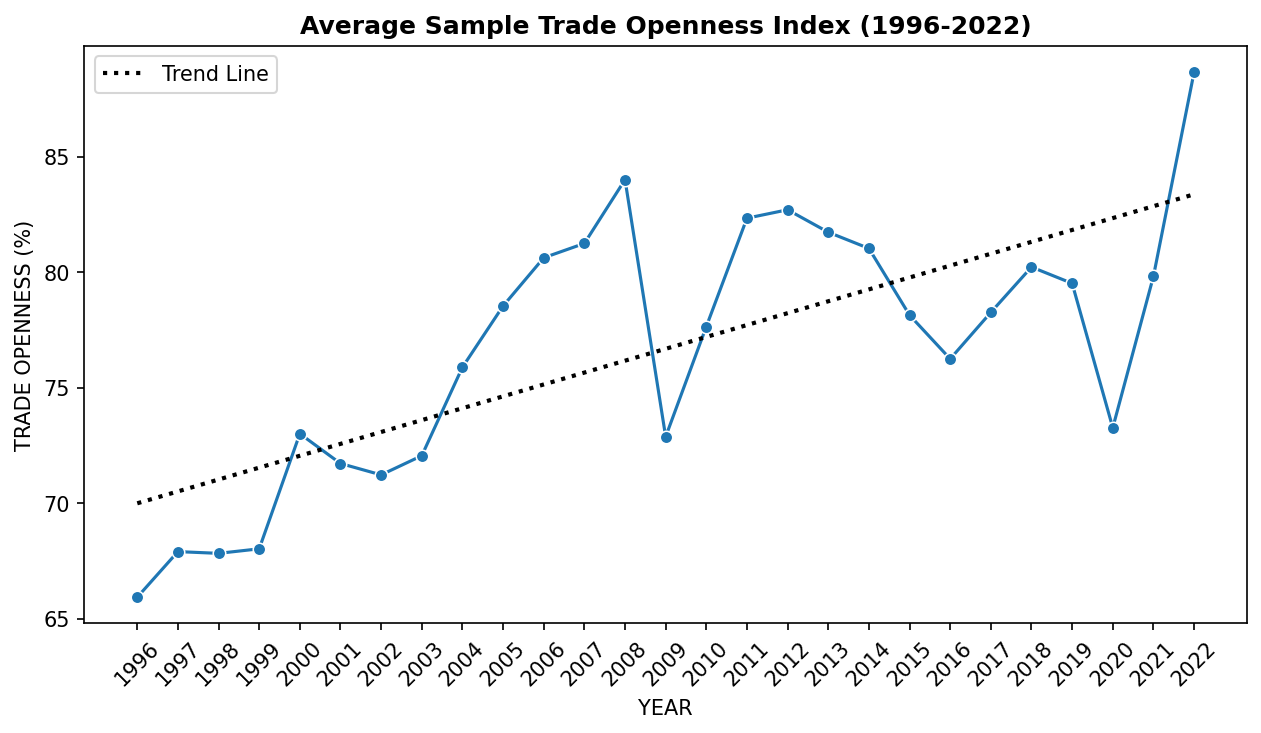

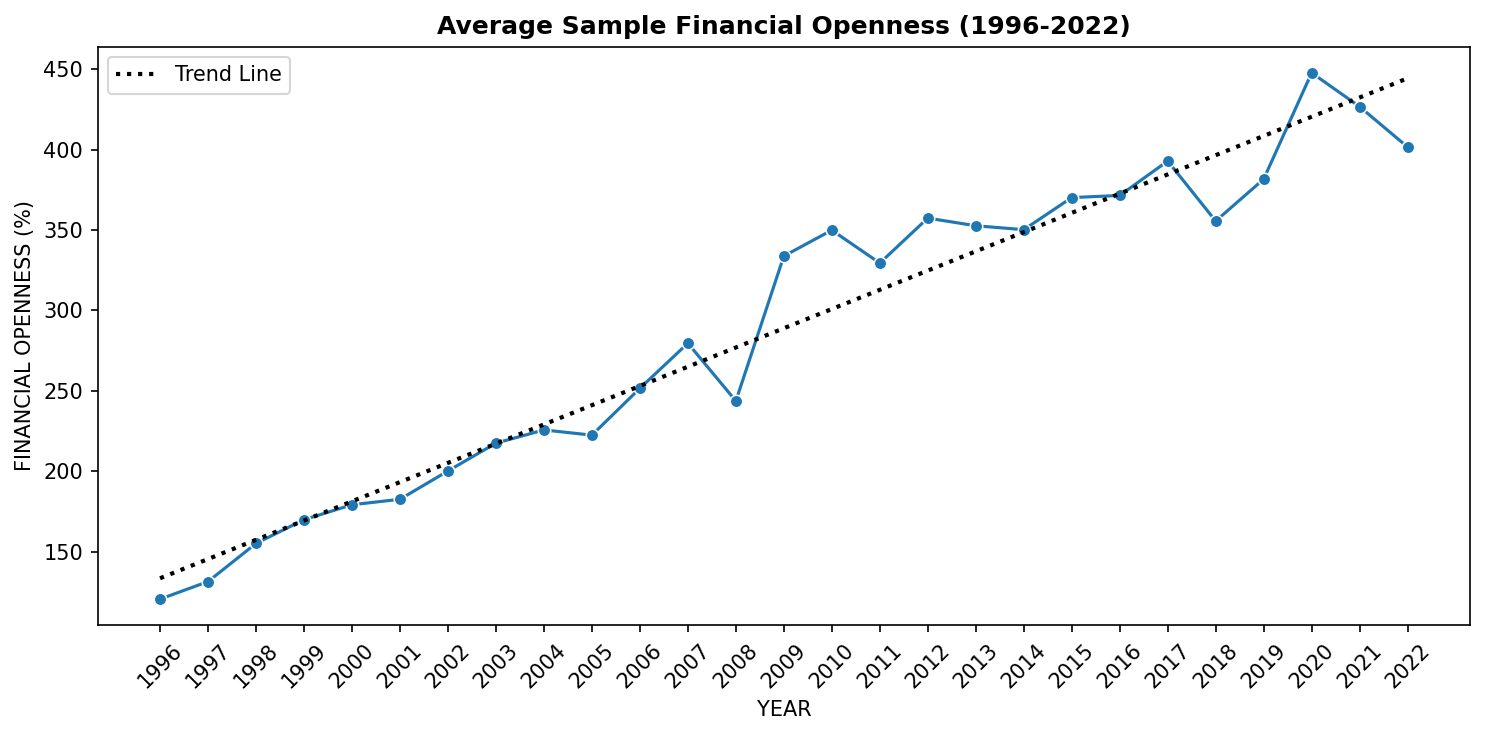

In [152]:
# Generate a plot data:
plot_data = world_year_group.copy()

# Plot the data for all time dependent variables:

# GDP per capita:
plt.figure()

sns.lineplot(data=plot_data, x='year', y='y', marker='o')
plt.title('Average Sample GDP per Capita (1996-2022)',
          fontdict={'weight': 'bold'})

trend_line(plot_data['year'],
           plot_data['y'],
           color='black')

plt.ylabel("GDP PER CAPITA (CONSTANT 2015 USD)")
plt.xlabel("YEAR")
plt.xticks(range(1996, 2023),
           rotation=45)

plt.legend()

# Investment rate:
plt.figure()

sns.lineplot(data=plot_data, x='year', y='I', marker='o')
plt.title('Average Sample Physical Capital Investment Rate (1996-2022)',
          fontdict={'weight': 'bold'})

trend_line(plot_data['year'],
           plot_data['I'],
           color='black')

plt.ylabel("PHYSICAL CAPITAL INVESTMENT RATE (% OF GDP)")
plt.xlabel("YEAR")
plt.xticks(range(1996, 2023),
           rotation=45)
plt.legend()

# Population growth rate:
plt.figure()

sns.lineplot(data=plot_data, x='year', y='n', marker='o')
plt.title('Average Sample Population Growth Rate (1996-2022)',
          fontdict={'weight': 'bold'})

trend_line(plot_data['year'],
           plot_data['n'],
           color='black')

# Population growth rate:
plt.ylabel("POPULATION GROWTH RATE (%)")
plt.xlabel("YEAR")
plt.ylim((0, 5))
plt.xticks(range(1996, 2023),
           rotation=45)

plt.legend()

# Human capital index:
plt.figure()

sns.lineplot(data=plot_data, x='year', y='HC', marker='o')
plt.title('Average Sample Human Capital Index (1996-2022)',
          fontdict={'weight': 'bold'})

trend_line(plot_data['year'],
           plot_data['HC'],
           color='black')

plt.ylabel("HUMAN CAPITAL INDEX")
plt.xlabel("YEAR")
plt.xticks(range(1996, 2023),
           rotation=45)

plt.legend()


# Rule of law index: 
plt.figure()

sns.lineplot(data=plot_data, x='year', y='INST', marker='o')
plt.title('Average Sample Rule of Law Index (1996-2022)',
          fontdict={'weight': 'bold'})

trend_line(plot_data['year'],
           plot_data['INST'],
           color='black')

plt.ylabel("RULE OF LAW INDEX")
plt.xlabel("YEAR")
plt.ylim((-2.5, 2.5))
plt.xticks(range(1996, 2023),
           rotation=45)

plt.legend()

# Trade openness:
plt.figure()

sns.lineplot(data=plot_data, x='year', y='TRADE', marker='o')
plt.title('Average Sample Trade Openness Index (1996-2022)',
          fontdict={'weight': 'bold'})

trend_line(plot_data['year'],
           plot_data['TRADE'],
           color='black')

plt.ylabel("TRADE OPENNESS (%)")
plt.xlabel("YEAR")
plt.xticks(range(1996, 2023),
           rotation=45)

plt.legend()

# Financial openness:
plt.figure()

sns.lineplot(data=plot_data, x='year', y='FINANCIAL', marker='o')
plt.title('Average Sample Financial Openness (1996-2022)',
          fontdict={'weight': 'bold'})

trend_line(plot_data['year'],
           plot_data['FINANCIAL'],
           color='black')

plt.ylabel("FINANCIAL OPENNESS (%)")
plt.xlabel("YEAR")
plt.xticks(range(1996, 2023),
           rotation=45)

plt.legend()

# Show all figures:
plt.tight_layout()
plt.show()

## PARTIAL REGRESSION PLOTS

In [153]:
# Define text annotate function:
def annotate_scatter_data(x: np.ndarray, y: np.ndarray,
                          txt_array: np.ndarray, oecd_array: np.array,
                          font_size: int) -> None:
    """Annotate scatter data for better visualization"""

    # Loop all country codes for each coordinate:
    for (x_val, y_val, txt_val, is_oecd) in zip(x, y, txt_array, oecd_array):
        
        # If oecd text color is red:
        if is_oecd:
            plt.annotate(txt_val, (x_val, y_val), ha='center', size=font_size, color='red')
        
        # Else blue:
        else:
            plt.annotate(txt_val, (x_val, y_val), ha='center', size=font_size, color='blue')

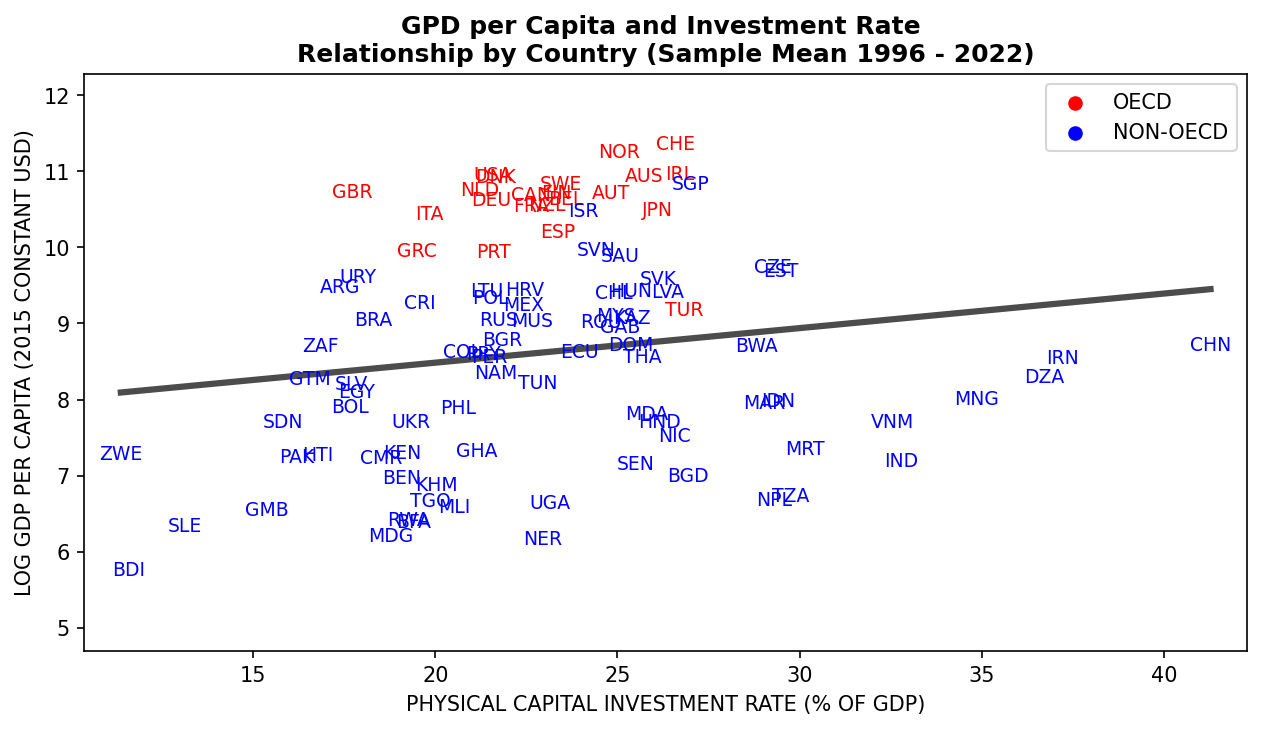

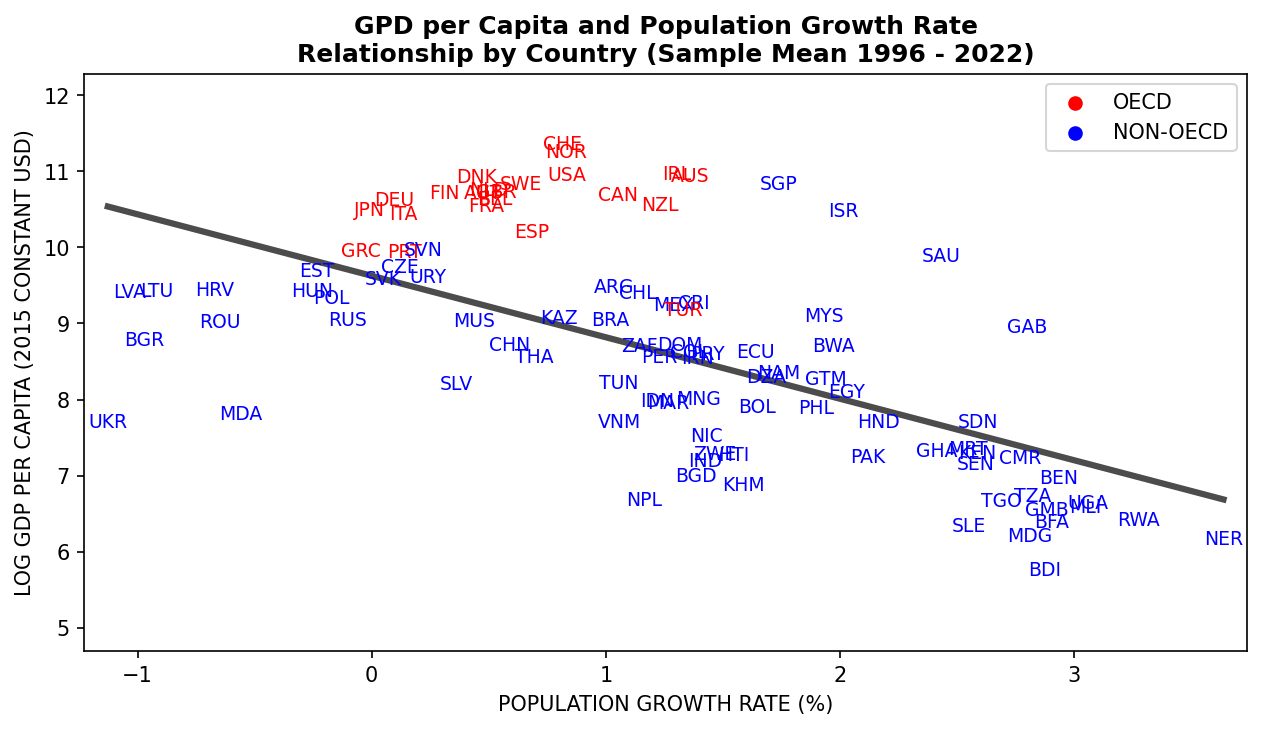

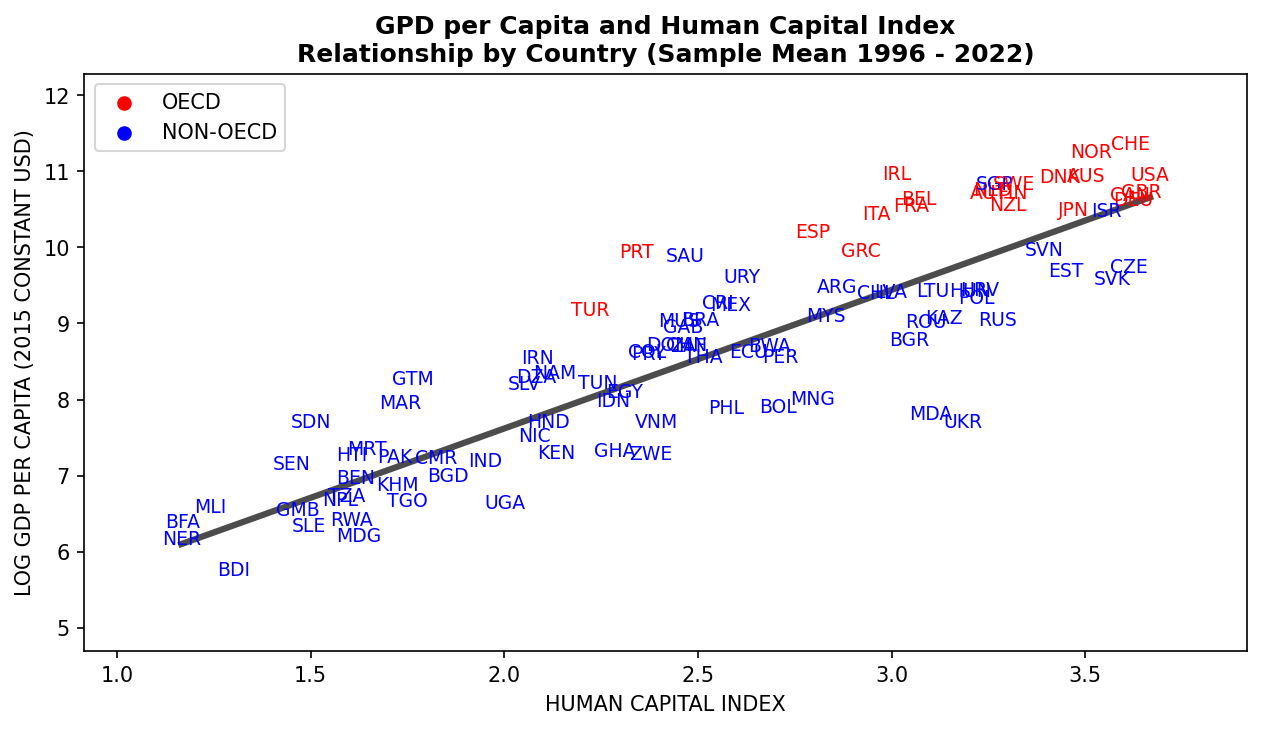

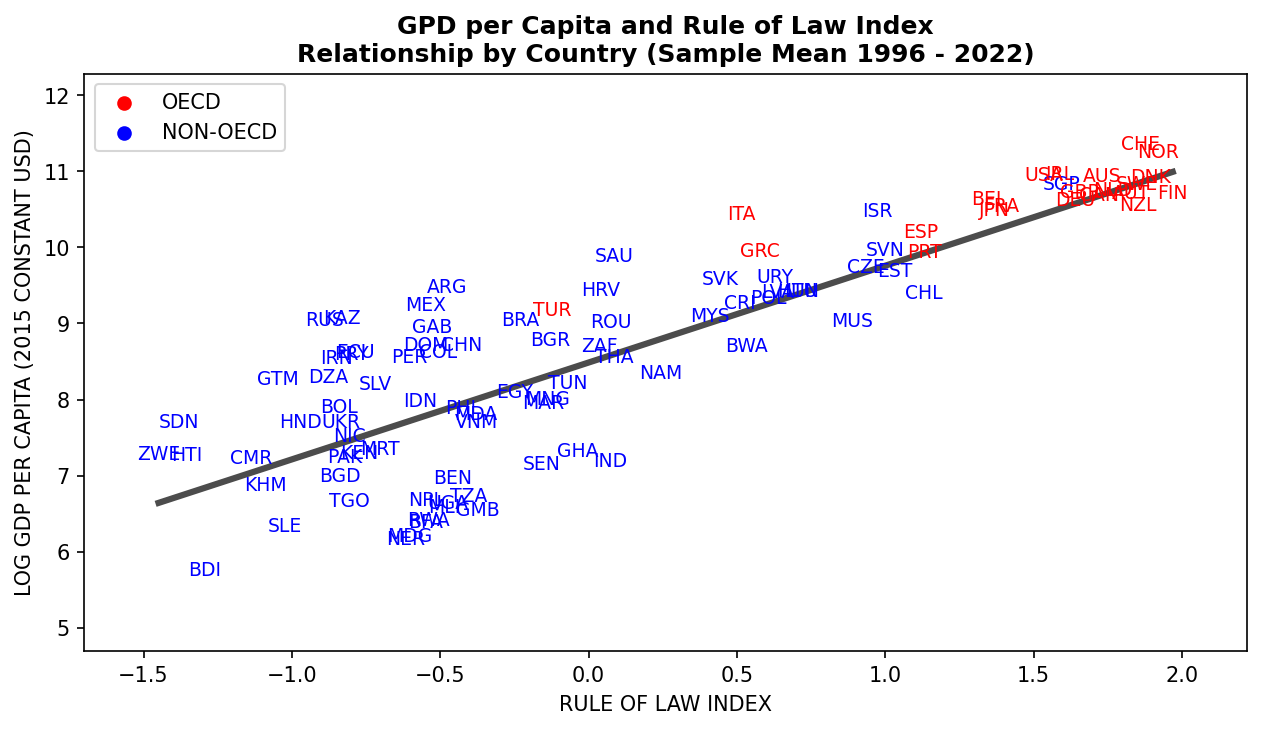

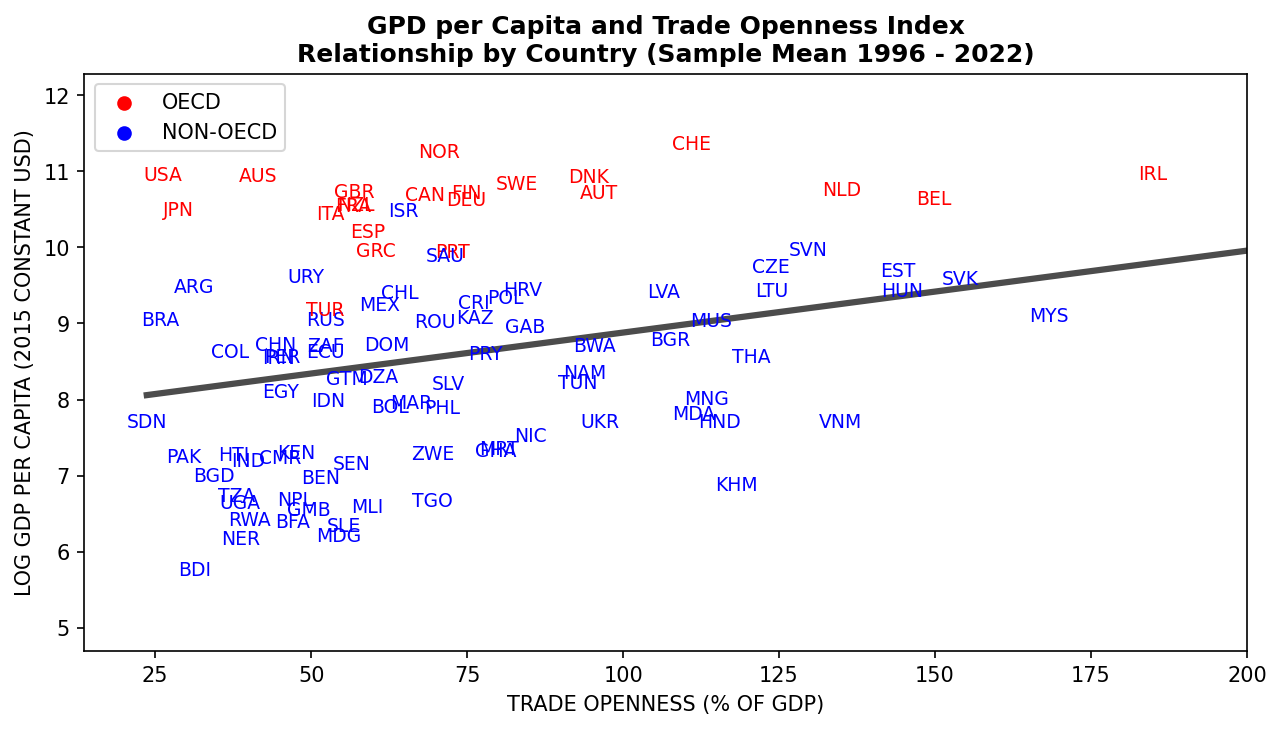

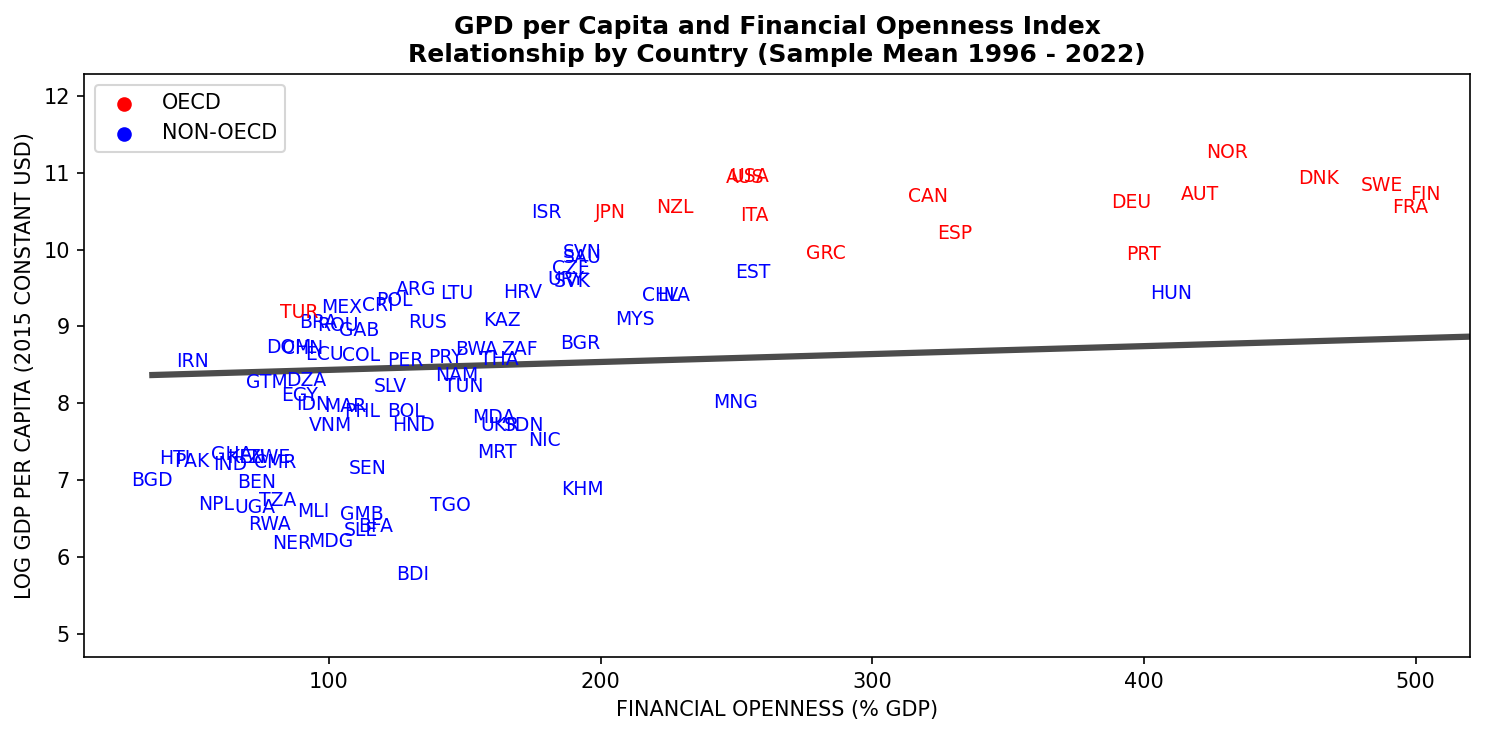

In [154]:
# Plot data as total sample average:
plot_data = df.groupby(by=['country', 'code']).mean().reset_index()
y = np.log(plot_data['y'])
codes = plot_data['code']
oecd = plot_data['OECD']

# Regression plots:

# I:
plt.figure()

x = plot_data['I']
sns.regplot(data=plot_data, x='I', y='ln_y',
            scatter_kws={'alpha': 0},
            line_kws={'color': 'black', 'linewidth': 3, 'alpha': 0.70},
            ci=False)

# Empty plots for legend:
plt.scatter([-1000], [-1000], color='red', label='OECD')
plt.scatter([-1000], [-1000], color='blue', label='NON-OECD')

# Annotation:
annotate_scatter_data(x=x, y=y,
                      txt_array=codes,
                      oecd_array=oecd,
                      font_size=9)

# Set limits for the axis:
plt.xlim((np.min(x) - 1, np.max(x) + 1))
plt.ylim((np.min(y) - 1, np.max(y) + 1))

# Set axis titles and plot title:
plt.title('GPD per Capita and Investment Rate \nRelationship by Country (Sample Mean 1996 - 2022)',
          fontdict={'weight': 'bold'})
plt.xlabel("PHYSICAL CAPITAL INVESTMENT RATE (% OF GDP)")
plt.ylabel('LOG GDP PER CAPITA (2015 CONSTANT USD)')
plt.legend()

# n
plt.figure()

x = plot_data['n']
sns.regplot(data=plot_data, x='n', y='ln_y',
            scatter_kws={'alpha': 0},
            line_kws={'color': 'black', 'linewidth': 3, 'alpha': 0.70},
            ci=False)

# Empty plots for legend:
plt.scatter([-1000], [-1000], color='red', label='OECD')
plt.scatter([-1000], [-1000], color='blue', label='NON-OECD')

# Annotation:
annotate_scatter_data(x=x, y=y,
                      txt_array=codes,
                      oecd_array=oecd,
                      font_size=9)

# Set limits for the axis:
plt.xlim((np.min(x) - 0.1, np.max(x) + 0.1))
plt.ylim((np.min(y) - 1, np.max(y) + 1))

# Set axis titles and plot title:
plt.title('GPD per Capita and Population Growth Rate\nRelationship by Country (Sample Mean 1996 - 2022)',
          fontdict={'weight': 'bold'})
plt.xlabel('POPULATION GROWTH RATE (%)')
plt.ylabel('LOG GDP PER CAPITA (2015 CONSTANT USD)')
plt.legend()

# HC
plt.figure()

x = plot_data['HC']
sns.regplot(data=plot_data, x='HC', y='ln_y',
            scatter_kws={'alpha': 0},
            line_kws={'color': 'black', 'linewidth': 3, 'alpha': 0.70},
            ci=False)

# Empty plots for legend:
plt.scatter([-1000], [-1000], color='red', label='OECD')
plt.scatter([-1000], [-1000], color='blue', label='NON-OECD')

# Annotation:
annotate_scatter_data(x=x, y=y,
                      txt_array=codes,
                      oecd_array=oecd,
                      font_size=9)

# Set limits for the axis:
plt.xlim((np.min(x) - 0.25, np.max(x) + 0.25))
plt.ylim((np.min(y) - 1, np.max(y) + 1))

# Set axis titles and plot title:
plt.title('GPD per Capita and Human Capital Index\nRelationship by Country (Sample Mean 1996 - 2022)',
          fontdict={'weight': 'bold'})
plt.xlabel('HUMAN CAPITAL INDEX')
plt.ylabel('LOG GDP PER CAPITA (2015 CONSTANT USD)')
plt.legend(loc='upper left')

# INST
plt.figure()

x = plot_data['INST']
sns.regplot(data=plot_data, x='INST', y='ln_y',
            scatter_kws={'alpha': 0},
            line_kws={'color': 'black', 'linewidth': 3, 'alpha': 0.70},
            ci=False)

# Empty plots for legend:
plt.scatter([-1000], [-1000], color='red', label='OECD')
plt.scatter([-1000], [-1000], color='blue', label='NON-OECD')

# Annotation:
annotate_scatter_data(x=x, y=y,
                      txt_array=codes,
                      oecd_array=oecd,
                      font_size=9)

# Set limits for the axis:
plt.xlim((np.min(x) - 0.25, np.max(x) + 0.25))
plt.ylim((np.min(y) - 1, np.max(y) + 1))

# Set axis titles and plot title:
plt.title('GPD per Capita and Rule of Law Index\nRelationship by Country (Sample Mean 1996 - 2022)',
          fontdict={'weight': 'bold'})
plt.xlabel('RULE OF LAW INDEX')
plt.ylabel('LOG GDP PER CAPITA (2015 CONSTANT USD)')
plt.legend(loc='upper left')

# TRADE
plt.figure()

x = plot_data['TRADE']
sns.regplot(data=plot_data, x='TRADE', y='ln_y',
            scatter_kws={'alpha': 0},
            line_kws={'color': 'black', 'linewidth': 3, 'alpha': 0.70},
            ci=False)

# Empty plots for legend:
plt.scatter([-1000], [-1000], color='red', label='OECD')
plt.scatter([-1000], [-1000], color='blue', label='NON-OECD')

# Annotation:
annotate_scatter_data(x=x, y=y,
                      txt_array=codes,
                      oecd_array=oecd,
                      font_size=9)

# Set limits for the axis:
plt.xlim((np.min(x) - 10, 200)) # IGNORE SGP for better visualization
plt.ylim((np.min(y) - 1, np.max(y) + 1))

# Set axis titles and plot title:
plt.title('GPD per Capita and Trade Openness Index\nRelationship by Country (Sample Mean 1996 - 2022)',
          fontdict={'weight': 'bold'})
plt.xlabel('TRADE OPENNESS (% OF GDP)')
plt.ylabel('LOG GDP PER CAPITA (2015 CONSTANT USD)')
plt.legend(loc='upper left')

# FINANCIAL
plt.figure()

x = plot_data['FINANCIAL']
sns.regplot(data=plot_data, x='FINANCIAL', y='ln_y',
            scatter_kws={'alpha': 0},
            line_kws={'color': 'black', 'linewidth': 3, 'alpha': 0.70},
            ci=False)

# Empty plots for legend:
plt.scatter([-1000], [-1000], color='red', label='OECD')
plt.scatter([-1000], [-1000], color='blue', label='NON-OECD')

# Annotation:
annotate_scatter_data(x=x, y=y,
                      txt_array=codes,
                      oecd_array=oecd,
                      font_size=9)

# Set limits for the axis:
plt.xlim((np.min(x) - 25, 520)) # ignore MUS, SGP, BEL, GRB, CHE for better visualization.
plt.ylim((np.min(y) - 1, np.max(y) + 1))

# Set axis titles and plot title:
plt.title('GPD per Capita and Financial Openness Index\nRelationship by Country (Sample Mean 1996 - 2022)',
          fontdict={'weight': 'bold'})
plt.xlabel('FINANCIAL OPENNESS (% GDP)')
plt.ylabel('LOG GDP PER CAPITA (2015 CONSTANT USD)')
plt.legend(loc='upper left')

# Show the plots:
plt.tight_layout()
plt.show()

## OECD COUNTRIES PRESENT IN THE DATASET

In [155]:
# List of OECD countries:
pd.Series(df.query('OECD == 1')['country'].unique())

0          Australia
1            Austria
2            Belgium
3             Canada
4            Denmark
5            Finland
6             France
7            Germany
8             Greece
9            Ireland
10             Italy
11             Japan
12       Netherlands
13       New Zealand
14            Norway
15          Portugal
16             Spain
17            Sweden
18       Switzerland
19            Turkey
20    United Kingdom
21     United States
dtype: object

## OECD AND NON-OECD DESCRIPTIVE STATISTICS

In [156]:
# OECD and underdeveloped countries statistics:
dev_and_underdeveloped = df[['y', 'I', 'n', 'HC',
                             'INST', 'TRADE', 'FINANCIAL', 'OECD']]\
    .groupby(by=['OECD']).mean().T

dev_and_underdeveloped

OECD,0,1
y,6043.3452,41275.5660
I,23.2039,23.1126
n,1.4115,0.6216
HC,2.3604,3.2227
INST,-0.2783,1.4607
TRADE,76.4192,77.6026
FINANCIAL,203.6107,583.6673


## TIME SERIES PLOTS WITH SAMPLE AVERAGE (1996 - 2022) FOR OECD and NON-OECD COUNTRIES

In [157]:
world_year_group_oecd =df[['year', 'y', 'ln_y', 'I', 'n', 'HC'
                           , 'INST', 'TRADE', 'FINANCIAL', 'OECD']].groupby(by=['OECD', 'year'], as_index=False).mean()

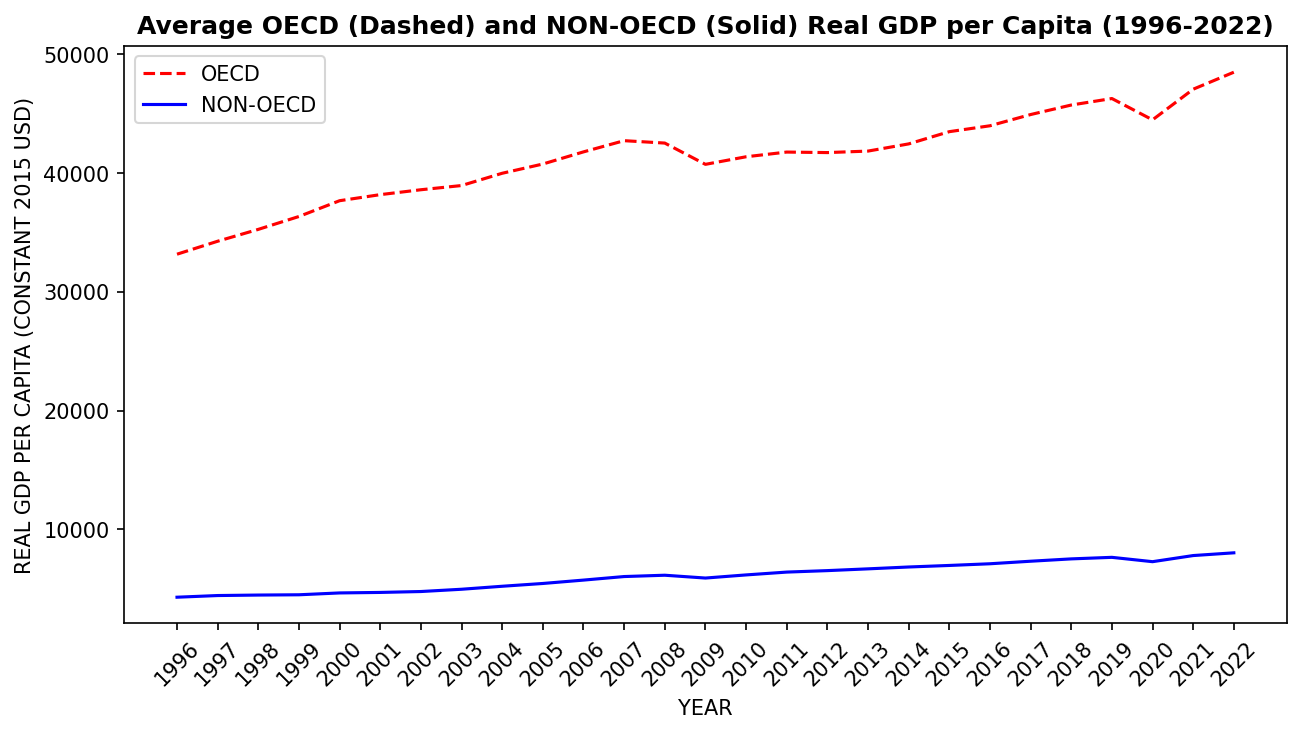

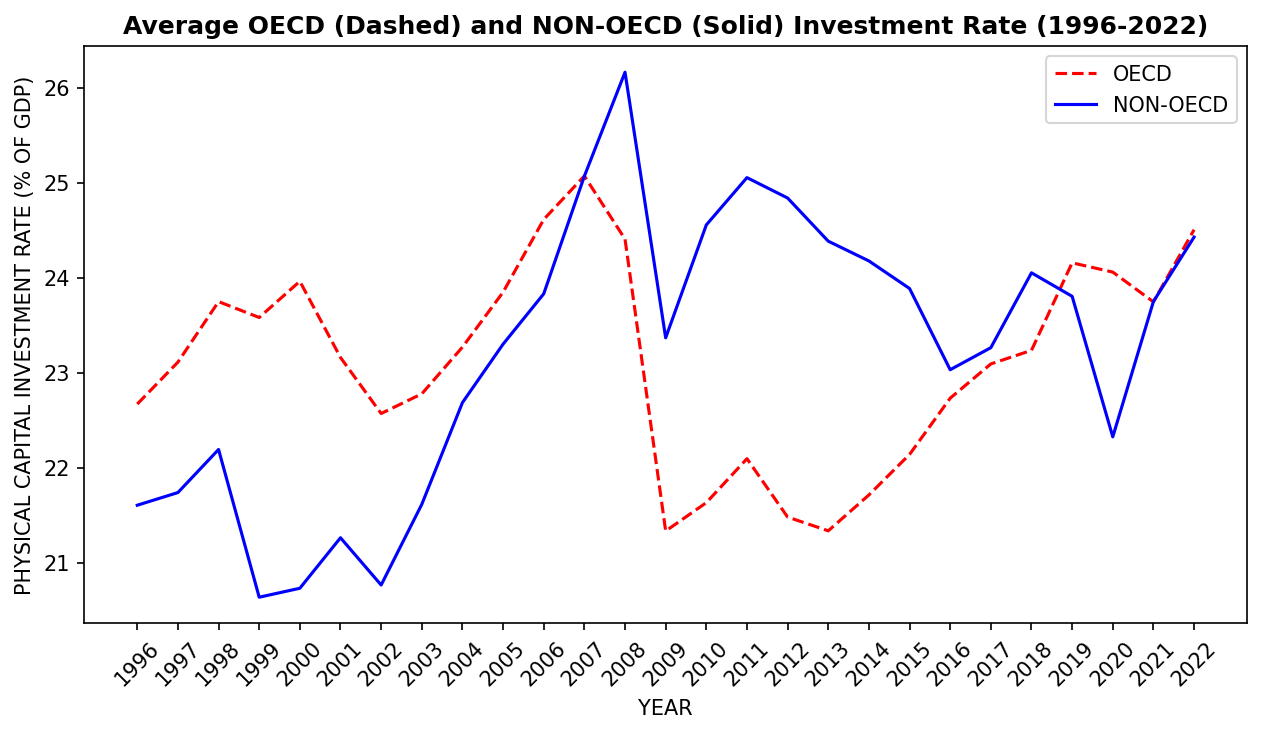

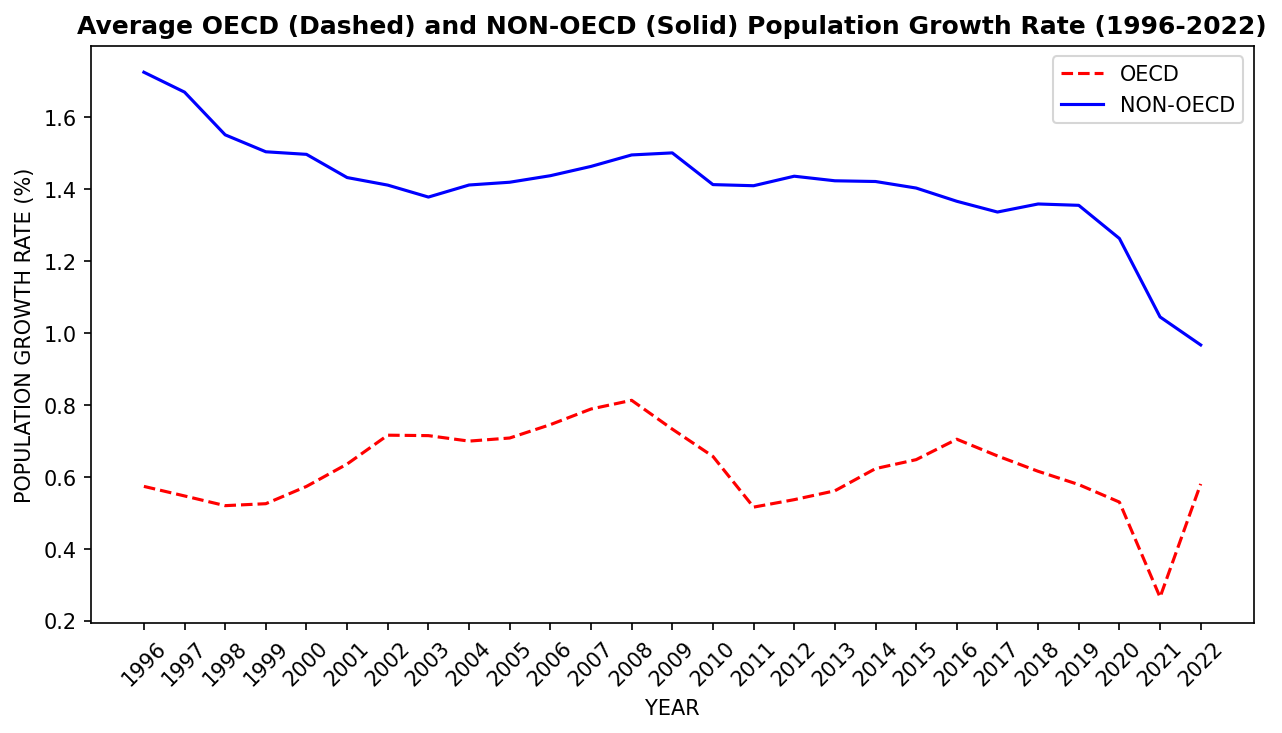

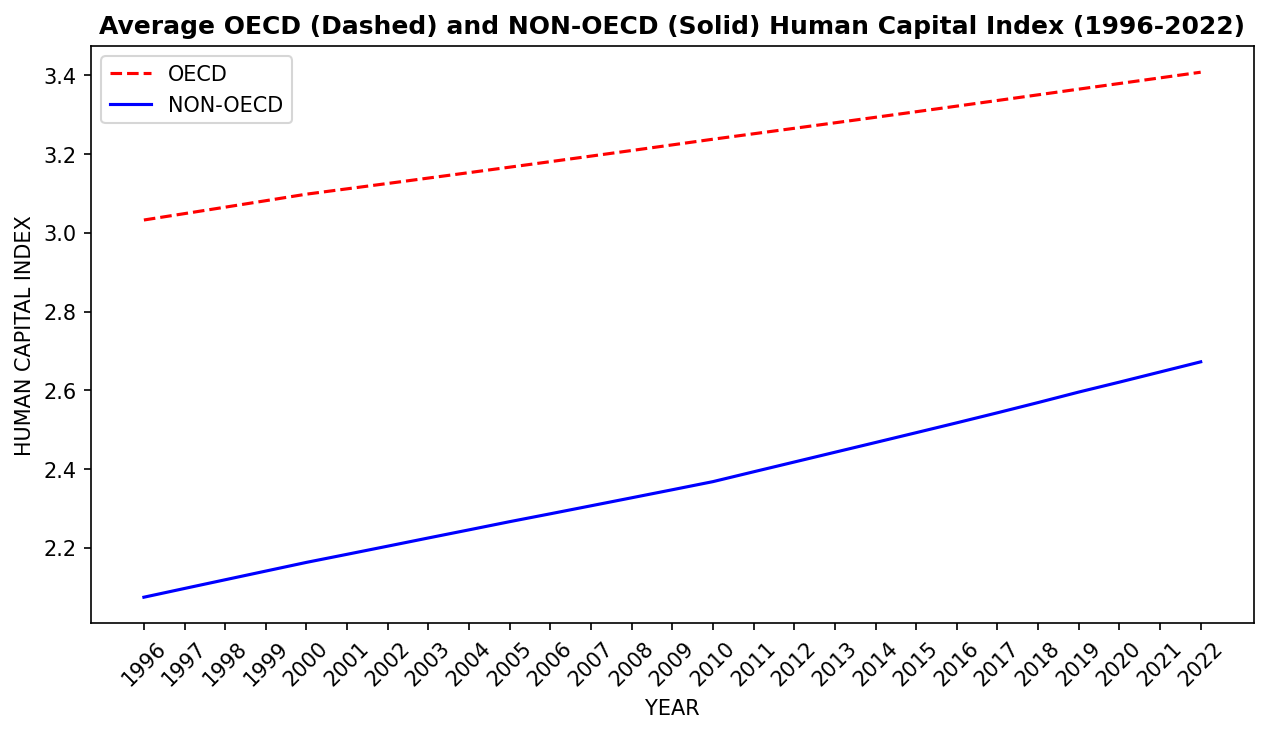

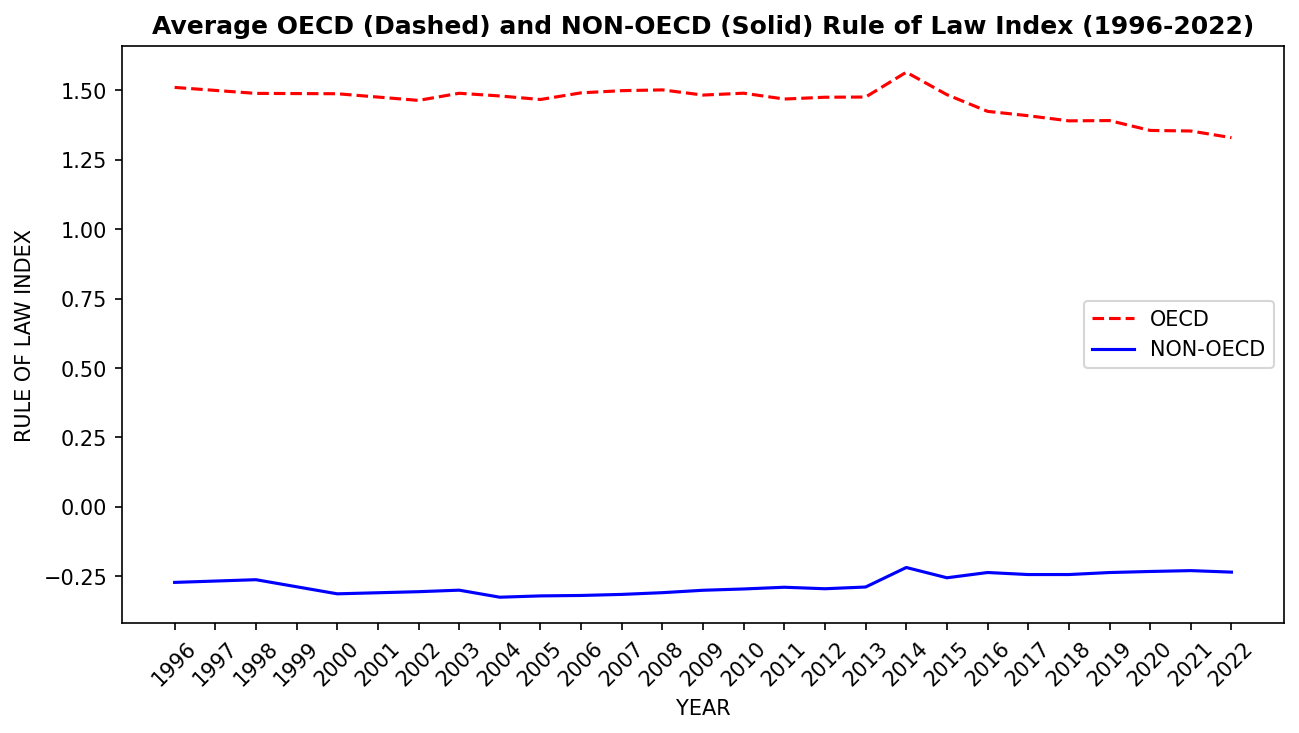

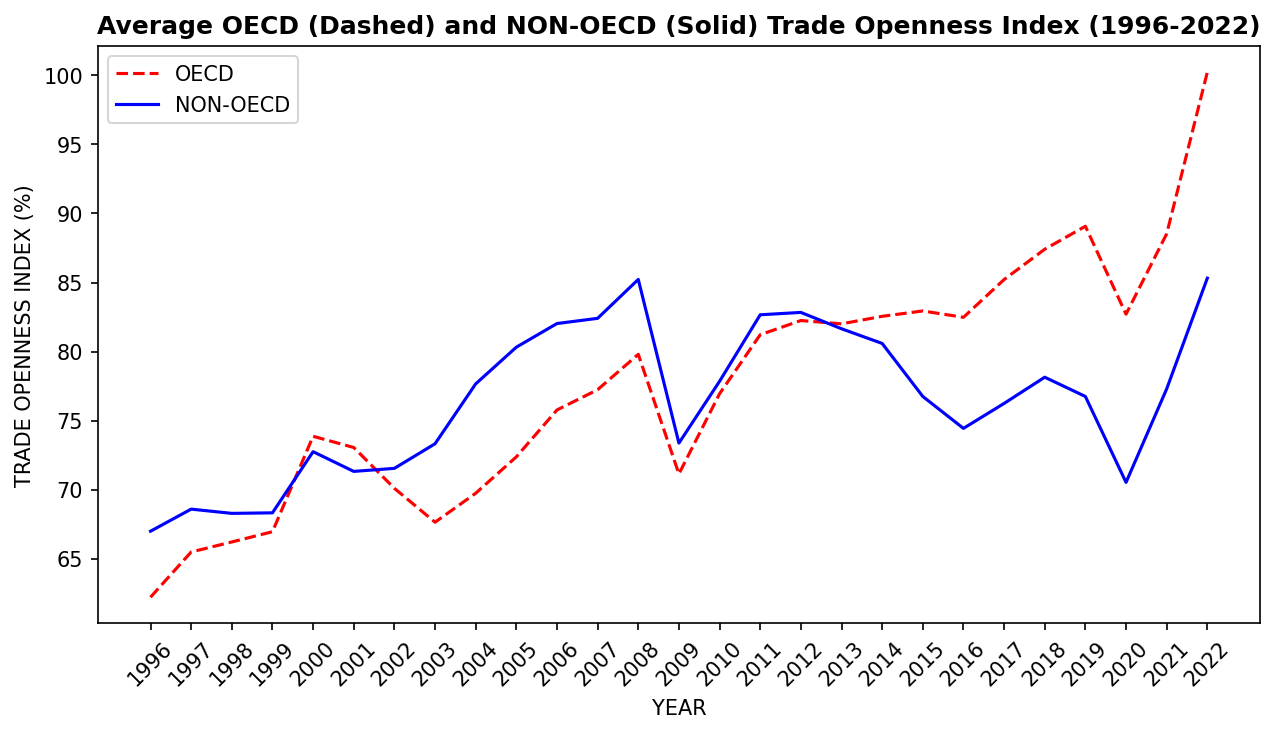

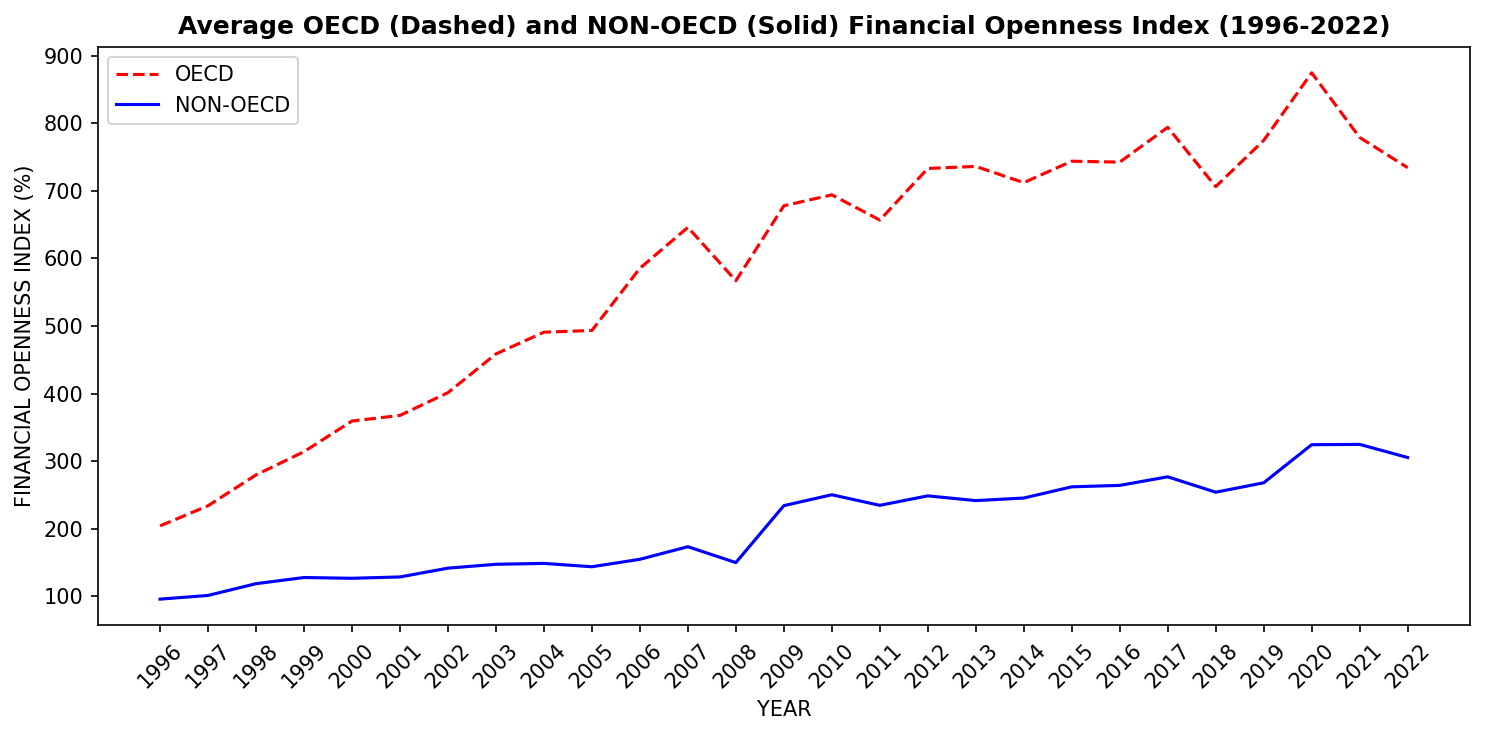

In [158]:
# Generate a plot data:
plot_data = world_year_group_oecd.copy()
plot_data.set_index(keys=['year'], inplace=True)
oecd = plot_data.query('OECD == 1')
non_oecd = plot_data.query('OECD == 0')

# Plot the figures:

# Real GDP per capita:
plt.figure()

oecd['y'].plot(c='r', ls='--', label='OECD')
non_oecd['y'].plot(c='b', label='NON-OECD')
plt.title('Average OECD (Dashed) and NON-OECD (Solid) Real GDP per Capita (1996-2022)',
          fontdict={'weight': 'bold'})

plt.xlabel('YEAR')
plt.ylabel("REAL GDP PER CAPITA (CONSTANT 2015 USD)")
plt.xticks(range(1996, 2023), rotation=45)
plt.legend()

# Investment Rates:
plt.figure()

oecd['I'].plot(c='r', ls='--', label='OECD')
non_oecd['I'].plot(c='b', label='NON-OECD')
plt.title('Average OECD (Dashed) and NON-OECD (Solid) Investment Rate (1996-2022)',
          fontdict={'weight': 'bold'})

plt.ylabel("PHYSICAL CAPITAL INVESTMENT RATE (% OF GDP)")
plt.xlabel("YEAR")
plt.xticks(range(1996, 2023), rotation=45)
plt.legend()

# Population growth rates:
plt.figure()

oecd['n'].plot(c='r', ls='--', label='OECD')
non_oecd['n'].plot(c='b', label='NON-OECD')
plt.title('Average OECD (Dashed) and NON-OECD (Solid) Population Growth Rate (1996-2022)',
          fontdict={'weight': 'bold'})

plt.ylabel("POPULATION GROWTH RATE (%)")
plt.xlabel("YEAR")
plt.xticks(range(1996, 2023), rotation=45)
plt.legend()

# Human Capital Index:
plt.figure()

oecd['HC'].plot(c='r', ls='--', label='OECD')
non_oecd['HC'].plot(c='b', label='NON-OECD')
plt.title('Average OECD (Dashed) and NON-OECD (Solid) Human Capital Index (1996-2022)',
          fontdict={'weight': 'bold'})

plt.ylabel("HUMAN CAPITAL INDEX")
plt.xlabel("YEAR")
plt.xticks(range(1996, 2023), rotation=45)
plt.legend()

# Rule of Law Index:
plt.figure()

oecd['INST'].plot(c='r', ls='--', label='OECD')
non_oecd['INST'].plot(c='b', label='NON-OECD')
plt.title('Average OECD (Dashed) and NON-OECD (Solid) Rule of Law Index (1996-2022)',
          fontdict={'weight': 'bold'})

plt.ylabel("RULE OF LAW INDEX")
plt.xlabel("YEAR")
plt.xticks(range(1996, 2023), rotation=45)
plt.legend()

# Trade opennnes index:
plt.figure()

oecd['TRADE'].plot(c='r', ls='--', label='OECD')
non_oecd['TRADE'].plot(c='b', label='NON-OECD')
plt.title('Average OECD (Dashed) and NON-OECD (Solid) Trade Openness Index (1996-2022)',
          fontdict={'weight': 'bold'})

plt.ylabel("TRADE OPENNESS INDEX (%)")
plt.xlabel("YEAR")
plt.xticks(range(1996, 2023), rotation=45)
plt.legend()

# Financial openness:
plt.figure()

oecd['FINANCIAL'].plot(c='r', ls='--', label='OECD')
non_oecd['FINANCIAL'].plot(c='b', label='NON-OECD')
plt.title('Average OECD (Dashed) and NON-OECD (Solid) Financial Openness Index (1996-2022)',
          fontdict={'weight': 'bold'})

plt.ylabel("FINANCIAL OPENNESS INDEX (%)")
plt.xlabel("YEAR")
plt.xticks(range(1996, 2023), rotation=45)
plt.legend()

# Show the plots:
plt.tight_layout()
plt.show()

## DISTRIBUTIONS OF INDEPENDENT VARIABLES

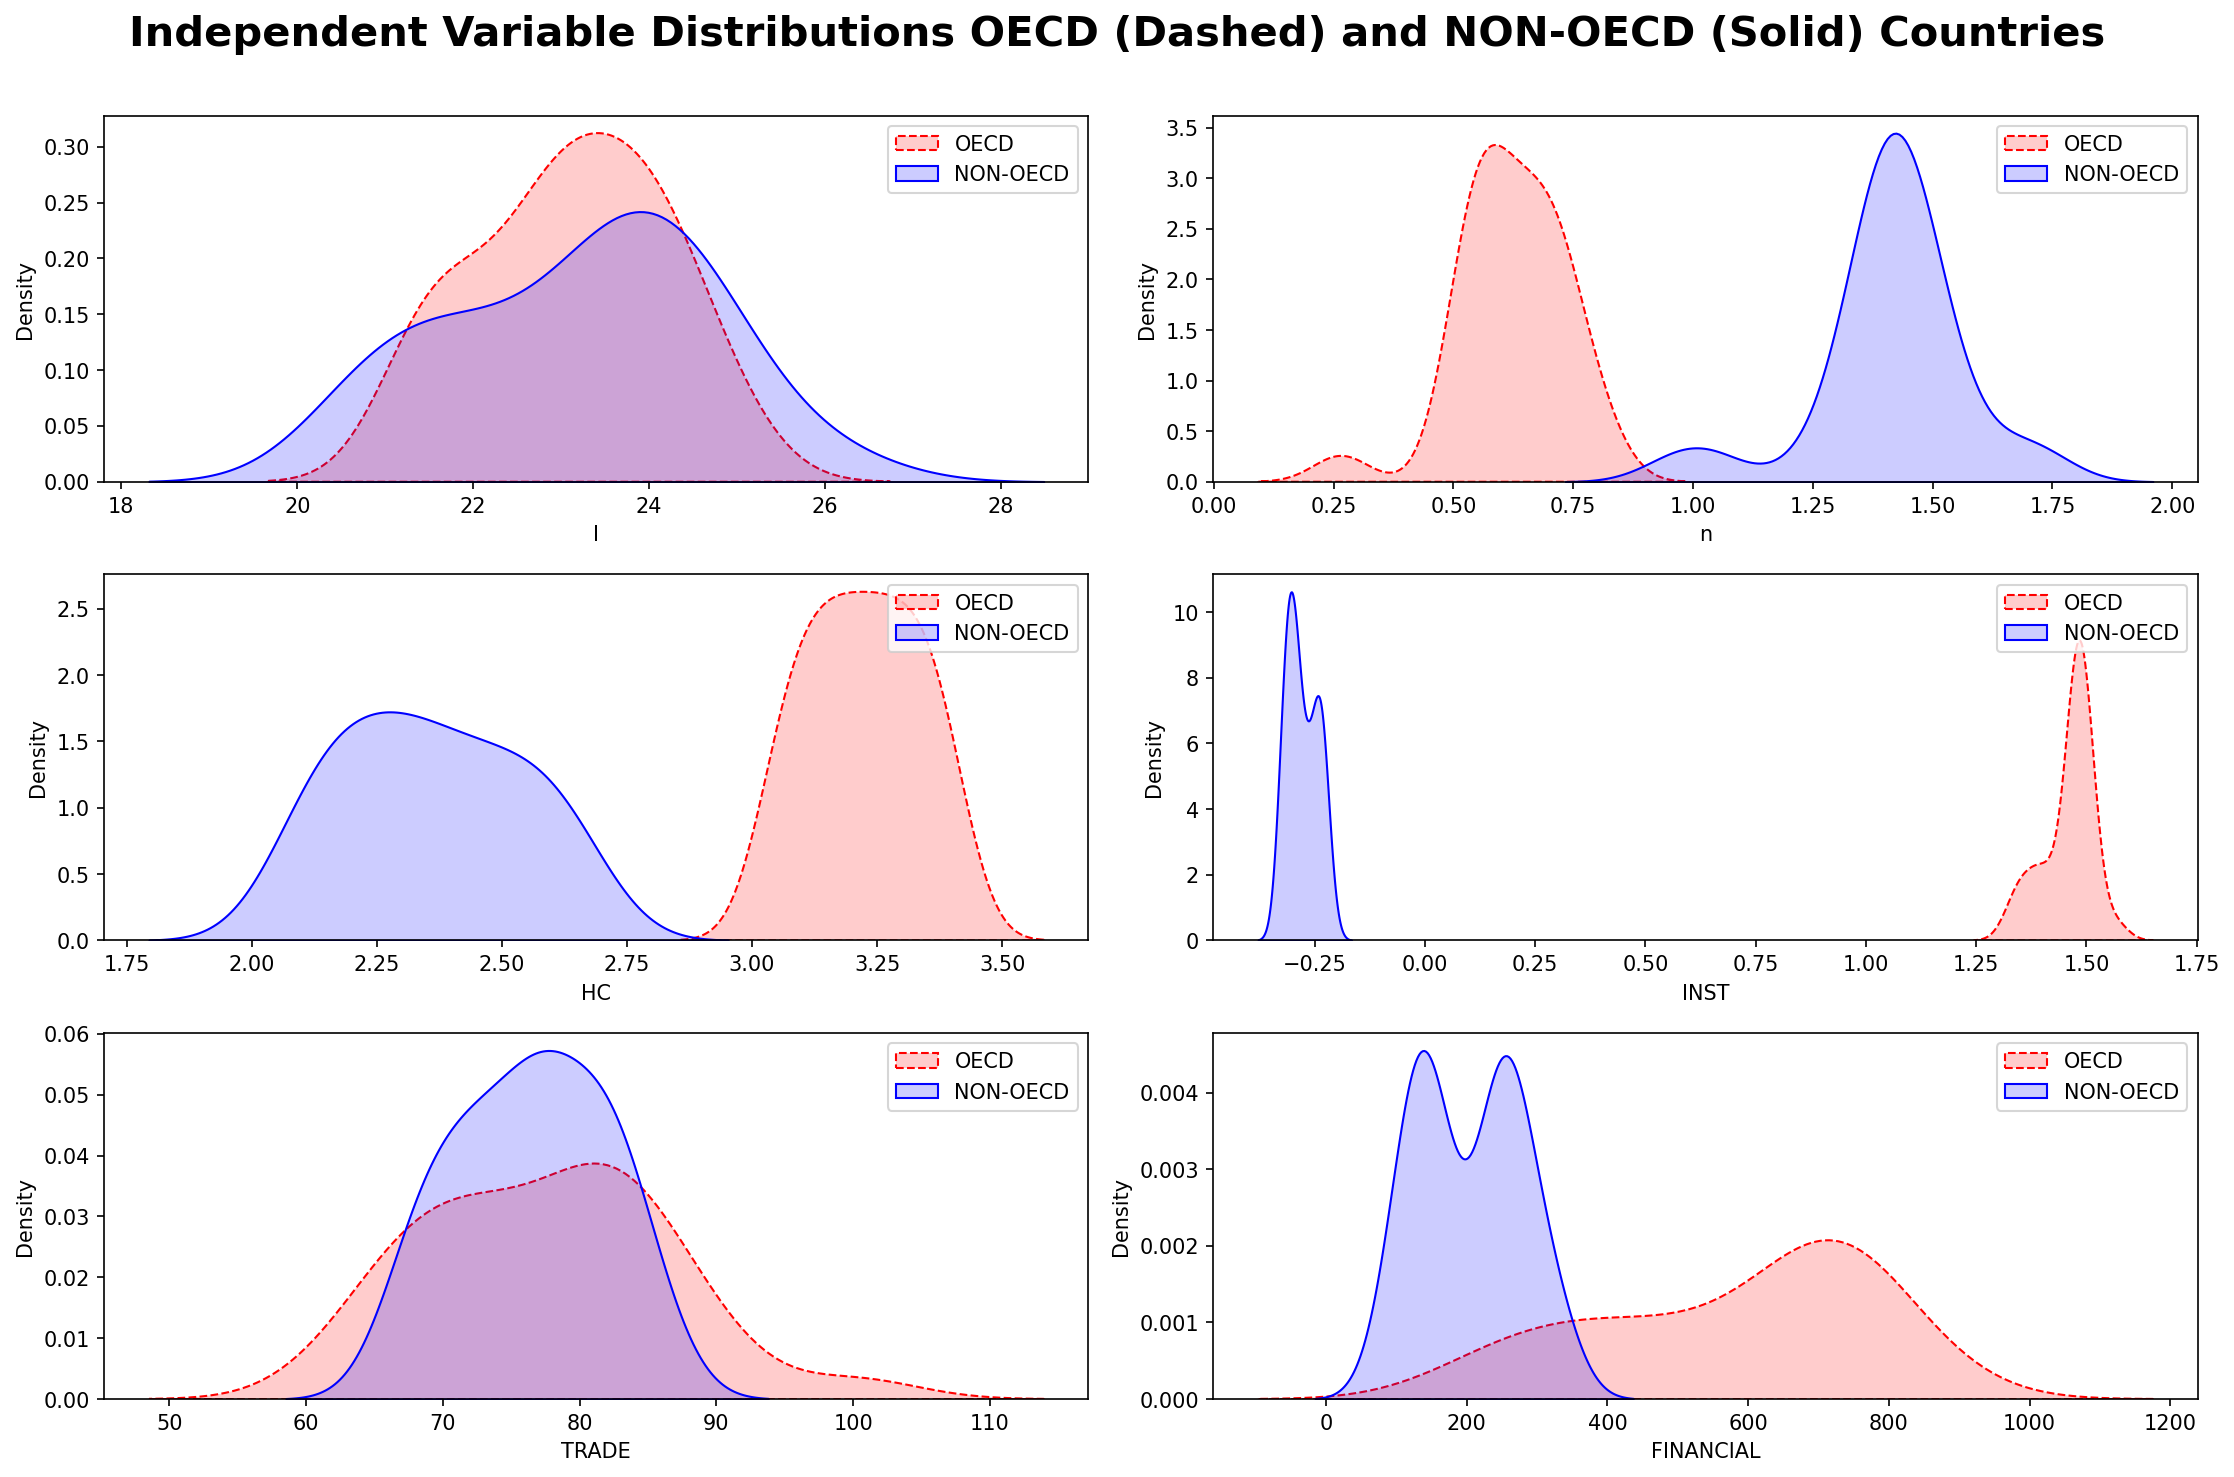

In [165]:
# Plot the KDE distributions:
plt.figure(figsize=(15, 10))

# Investment:
plt.subplot(321)

sns.kdeplot(data=oecd, x='I', fill=True, alpha=0.20, ls='--', color='r', label='OECD')
sns.kdeplot(data=non_oecd, x='I', fill=True, alpha=0.20, color='b' ,label='NON-OECD')
plt.legend()


# Population Growth:
plt.subplot(322)

sns.kdeplot(data=oecd, x='n', fill=True, alpha=0.20, ls='--', color='r', label='OECD')
sns.kdeplot(data=non_oecd, x='n', fill=True, alpha=0.20, color='b' ,label='NON-OECD')
plt.legend()


# Human Capital Index:
plt.subplot(323)

sns.kdeplot(data=oecd, x='HC', fill=True, alpha=0.20, ls='--', color='r', label='OECD')
sns.kdeplot(data=non_oecd, x='HC', fill=True, alpha=0.20, color='b' ,label='NON-OECD')
plt.legend()


# Rule of Law Index:
plt.subplot(324)

sns.kdeplot(data=oecd, x='INST', fill=True, alpha=0.20, ls='--', color='r', label='OECD')
sns.kdeplot(data=non_oecd, x='INST', fill=True, alpha=0.20, color='b' ,label='NON-OECD')
plt.legend()


# Trade Openness Index:
plt.subplot(325)

sns.kdeplot(data=oecd, x='TRADE', fill=True, alpha=0.20, ls='--', color='r', label='OECD')
sns.kdeplot(data=non_oecd, x='TRADE', fill=True, alpha=0.20, color='b' ,label='NON-OECD')
plt.legend()


# Financial Openness Index:
plt.subplot(326)

sns.kdeplot(data=oecd, x='FINANCIAL', fill=True, alpha=0.20, ls='--', color='r', label = 'OECD')
sns.kdeplot(data=non_oecd, x='FINANCIAL', fill=True, alpha=0.20, color='b' ,label='NON-OECD')
plt.legend()

# Set title for all plots:
plt.suptitle('Independent Variable Distributions OECD (Dashed) and NON-OECD (Solid) Countries\n', fontsize=20, weight='bold')

plt.tight_layout()
plt.show()

# DISCUSSION ON THE VARIANCE OF y

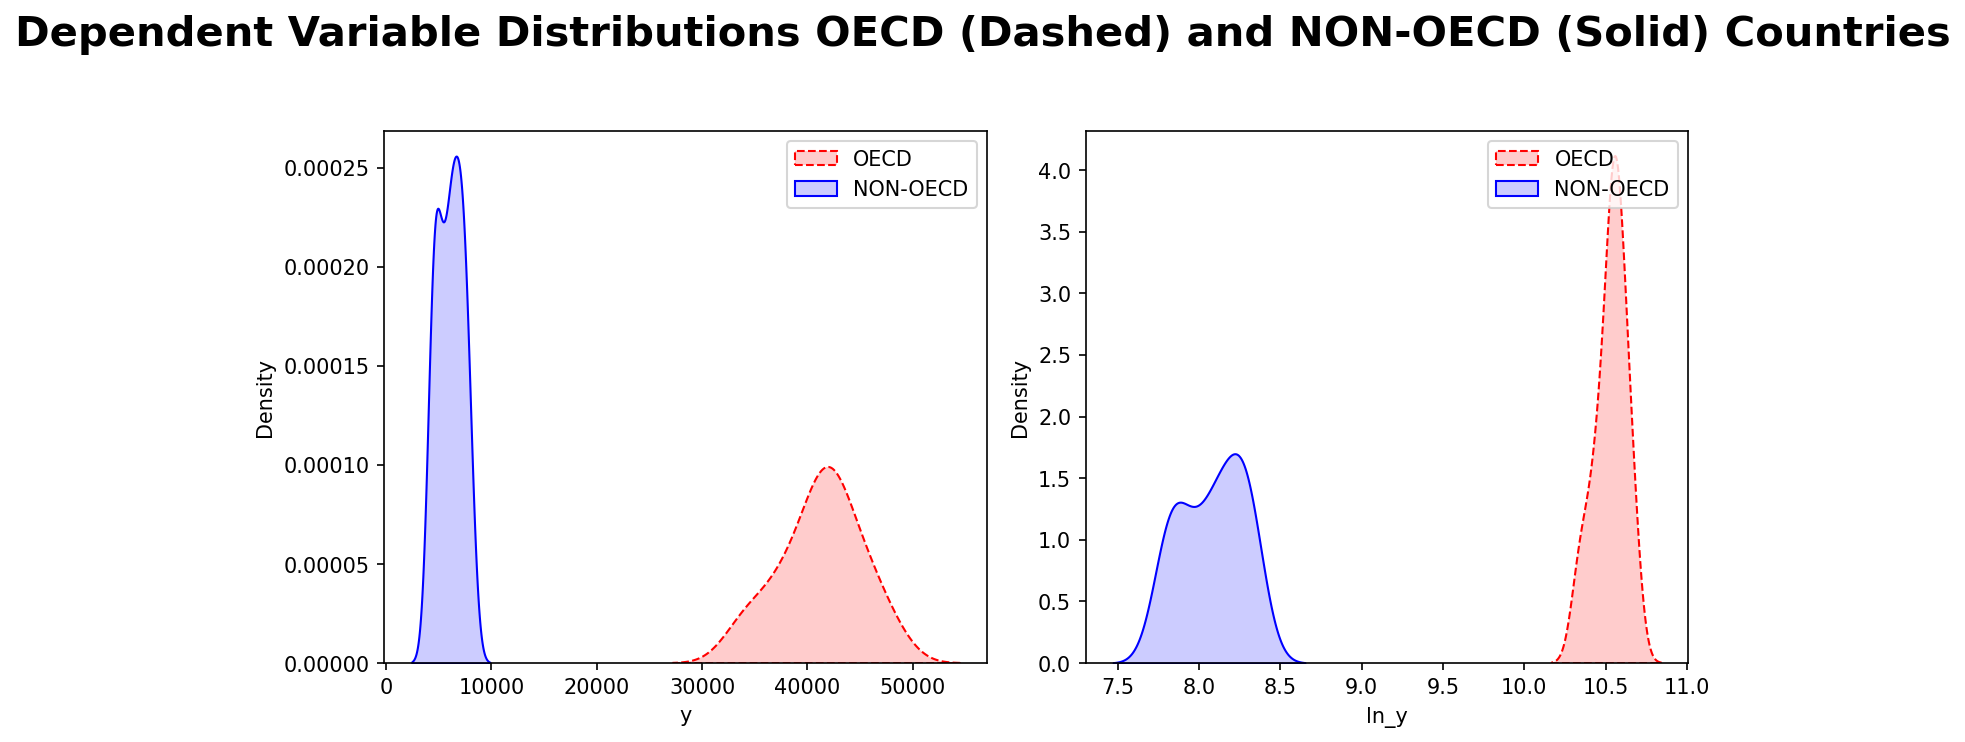

In [160]:
plt.figure()

plt.subplot(121)
sns.kdeplot(data=oecd, x='y', fill=True, alpha=0.20, ls='--', color='r', label='OECD')
sns.kdeplot(data=non_oecd, x='y', fill=True, alpha=0.20, color='b' ,label='NON-OECD')
plt.legend()

plt.subplot(122)
sns.kdeplot(data=oecd, x='ln_y', fill=True, alpha=0.20, ls='--', color='r', label='OECD')
sns.kdeplot(data=non_oecd, x='ln_y', fill=True, alpha=0.20, color='b' ,label='NON-OECD')
plt.legend()

plt.suptitle('Dependent Variable Distributions OECD (Dashed) and NON-OECD (Solid) Countries\n', fontsize=20, weight='bold')
plt.tight_layout()
plt.show()

## CORRELATION MATRIX

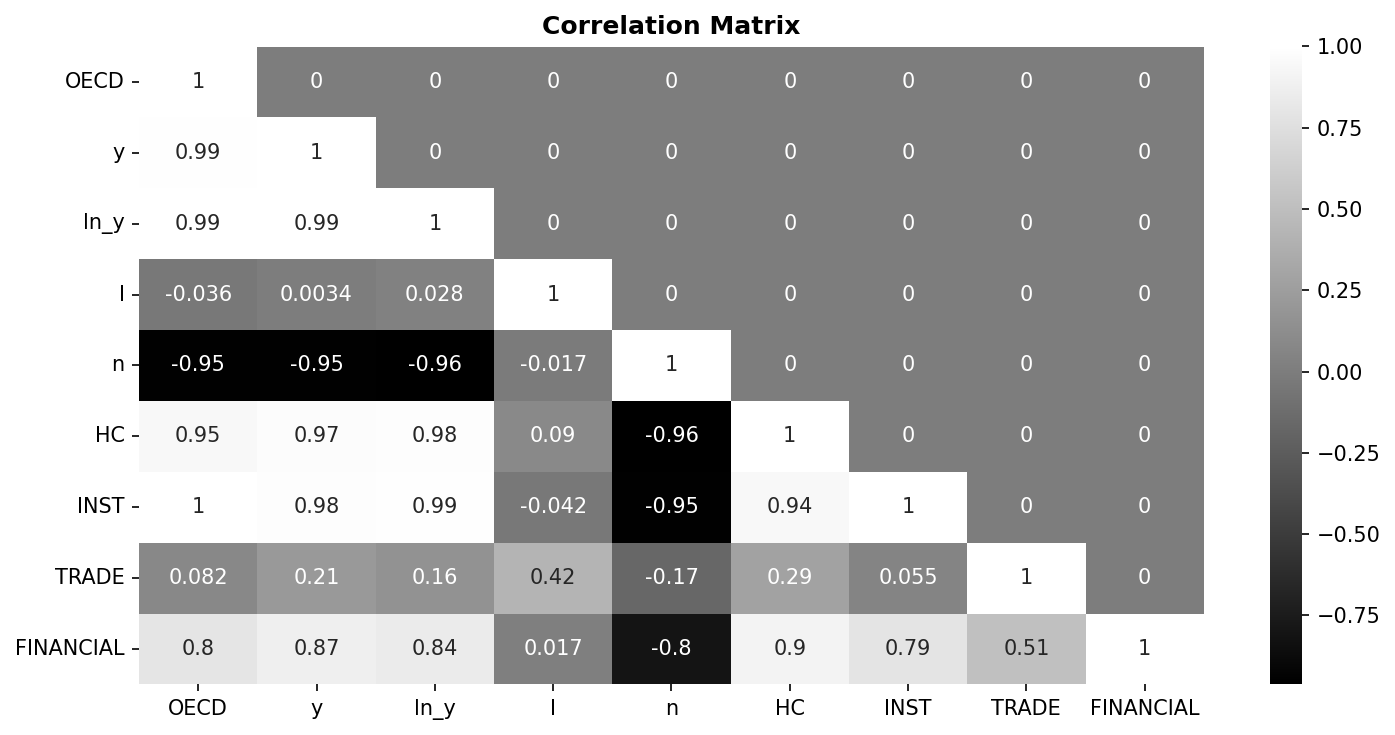

In [161]:
plt.figure()

corrolation_data = pd.DataFrame(np.tril(plot_data.corr()),
                                columns=plot_data.columns, index=plot_data.columns)

sns.heatmap(corrolation_data, annot=True, cbar=True, cmap='gray')
plt.title('Correlation Matrix', fontdict={'weight': 'bold'})

plt.tight_layout()
plt.show()

In [162]:
corrolation_data

,OECD,y,ln_y,I,n,HC,INST,TRADE,FINANCIAL
OECD,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
y,0.9876,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
ln_y,0.9927,0.9934,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
I,-0.0357,0.0034,0.0282,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000
n,-0.9498,-0.9482,-0.9624,-0.0170,1.0000,0.0000,0.0000,0.0000,0.0000
HC,0.9461,0.9716,0.9771,0.0898,-0.9602,1.0000,0.0000,0.0000,0.0000
INST,0.9987,0.9826,0.9916,-0.0421,-0.9482,0.9444,1.0000,0.0000,0.0000
TRADE,0.0819,0.2137,0.1570,0.4242,-0.1690,0.2858,0.0552,1.0000,0.0000
FINANCIAL,0.7980,0.8744,0.8416,0.0174,-0.8029,0.9024,0.7877,0.5100,1.0000


## MULTICOLINEARITY TEST

In [163]:
# This test tries to assess the multicolinearity between independent variables.
# A variance influence factor bigger than 10 indicates multicolinearity between variables.
# However, most of the econometric studies tend to ignore this problem, so we will.

In [164]:
# the independent variables set 
X = plot_data.reset_index().drop(columns=['year', 'y', 'ln_y'])

# VIF dataframe 
vif_data = pd.DataFrame() 
vif_data["X"] = X.columns 

# calculating VIF for each feature 
vif_data["Variance Influence Factor"] = [variance_inflation_factor(X.values, i)
                                        for i in range(len(X.columns))] 

vif_data

,X,Variance Influence Factor
0,OECD,1090.8501
1,I,676.1630
2,n,49.5310
3,HC,699.8699
4,INST,887.4418
5,TRADE,494.4118
6,FINANCIAL,34.3618


# APPENDIX

In [171]:
appendix = df.groupby(by=['country','code', 'OECD'], as_index=False).first()[['country','code', 'OECD']]

In [173]:
appendix['OECD'] = appendix['OECD'].astype(bool)

In [176]:
appendix

,country,code,OECD
0,Algeria,DZA,False
1,Argentina,ARG,False
2,Australia,AUS,True
3,Austria,AUT,True
4,Bangladesh,BGD,False
...,...,...,...
93,United Kingdom,GBR,True
94,United States,USA,True
95,Uruguay,URY,False
96,Vietnam,VNM,False
